#Contexte

Compétition Kaggle organisée par Go Daddy. Il s'agit de prédire la densité des microentreprises sur des comtés des USA sur une période. La contrainte est de construction son modèle de ML en minimisant la métrique SMAPE.

# Mon Sommaire 

- <a href ="#1"> Import </a>
- <a href ="#2"> Import libraries </a>
- <a href ="#3"> Functions </a>
- <a href ="#4"> Param </a>
- <a href ="#5"> Read data </a>
- <a href ="#6"> df train all</a>
- <a href ="#7"> df test all </a>
- <a href ="#8"> Viz data train all</a>
- <a href ="#9"> Outliers</a>
- <a href ="#10"> Features engineering</a>
- <a href ="#11"> Dataframe for prediction with density shift features</a>
  - <a href ="#111"> df pred density</a>
  - <a href ="#112"> data features/target </a>
  - <a href ="#113"> Preproc </a>
    - <a href ="#1131"> Robustscaler </a>
    - <a href ="#1132"> StandardScaler </a>
  - <a href ="#114"> Split data </a>
  - <a href ="#115"> Linear Regression</a>
  - <a href ="#116"> Pred for sample submission with Linear Reg</a>
  - <a href ="#117"> Random Forest</a>
  - <a href ="#11"> GradientBoosting StandardScaler</a>
  - <a href ="#119"> GradientBoosting Robustscaler</a>
- <a href ="#12"> Sample submission</a>
  - <a href ="#121"> read sample submission file</a>
  - <a href ="#122"> concat all predicts</a>
  - <a href ="#123"> to_csv</a>

# <a name = "1">Import</a>

In [348]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <a name = "2">Import libraries</a>

In [349]:
#import gc
import numpy as np
import pandas as pd
import xgboost as xgb
#from tqdm.notebook import tqdm
import os
# Plz install these packages if you want to make choropleth map.
!pip install plotly-geo
!pip install pyshp
!pip install geopandas
!pip install probatus


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [350]:
#visualisatoin
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
import plotly.figure_factory as ff
import geopandas
import shapely

import warnings
warnings.filterwarnings("ignore")

from urllib.request import urlopen
import json
import plotly.express as px

In [351]:
#preprocessing normalisation for modelling
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

In [352]:
from probatus.utils import Scorer
from sklearn.metrics import make_scorer

In [353]:
#algorithm for modelling in classification case
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [354]:
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


In [355]:
from nbpep8.nbpep8 import pep8

#<a name = "3">Functions </a>

In [356]:
def smape(y_true, y_pred):
    """
    Give the metric smape (Symmetric Mean Absolute Percentage Error)

    Parameters
    ----------
    y_true : float, series
        real value of the target
    y_pred : float, series
        predict value of the target

    Returns
    -------
    float, metric smape

    """

    smap = np.zeros(len(y_true))
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    pos_ind = (y_true != 0) | (y_pred != 0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    return 100 * np.mean(smap)


pep8(_ih)

In [357]:
def hist_box_plot(df,
                  col="energy_100g",
                  subtitle="Visualisation de la distribution de"
                           "la variable energy_100g",
                  hist_title='Histogramme de la variable energy_100g',
                  color='skyblue'):
    """
    Give visualisations of quantitative feature

    Parameters
    ----------
    df  : dataframe
    col : feature
    subtitle : description of the visualisation
    hist_title : title of the histogramme visualisation
    color : color of the visualisaton

    Returns
    -------
    Give 2 visualisations of a quantitative feature, histplot and boxplot

    """

    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15, 6))
    fig.suptitle(subtitle)
    sns.histplot(df, x=col, bins="sturges", kde=True, ax=ax[0])
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Nombre d'observations")
    ax[0].set_title(hist_title)

    sns.boxplot(df[col], x=col, color=color, ax=ax[1])
    ax[1].set_title(f'Boite à moustache de la variable {col}')
    ax[1].set_xlabel(col)
    plt.show()

    print('-' * 223)
    print("Indicateurs de distribution")
    print(df[col].describe())


pep8(_ih)

In [358]:
def heatmap(df):
    """
    Give a heatmap visualisation

    Parameters
    ----------
    df  : dataframe

    Returns
    -------
    Give a heatmap visualisation of features of df

    """
    plt.figure(figsize=(10, 7))
    plt.title("Heatmap correlation", fontsize=14, loc='center')
    heatmap_reg = sns.heatmap(df.corr(), cmap="PiYG", robust=True, annot=True,
                              annot_kws={'size': 10}, fmt=".1f", vmin=-1,
                              vmax=1)
    square = True


pep8(_ih)

In [359]:
def smooth(df, coln):
    """
    Smooth outliers with winsorising and IQR

    Parameters
    ----------
    df : dataframe
    coln : features

    Returns
    -------
    dataframe with no outliers

    """
    for i in range(0, len(coln)):
        data_stats = df.copy(deep=True)
        data_stats = data_stats.loc[:, ["cfips", coln[i]]]
        data_stats["cfips"] = data_stats["cfips"].astype(str)

        stats = data_stats.describe().transpose()
        stats['IQR'] = stats['75%'] - stats['25%']

        outliers = pd.DataFrame(columns=stats.columns)

        for col in stats.index:
            iqr = stats.at[col, 'IQR']
            cutoff = iqr * 1.5
            lower = stats.at[col, '25%'] - cutoff
            upper = stats.at[col, '75%'] + cutoff
            results = data_stats[(data_stats[col] < lower) |
                                 (data_stats[col] > upper)].copy()
            results['Outlier'] = col
            outliers = outliers.append(results)
        outliers.reset_index(inplace=True)
        idx = outliers["index"].tolist()

        for j in idx:
            out = df.iloc[idx, df.columns.get_loc(coln[i])].tolist()[0]
            if out > upper:
                df.iloc[idx, df.columns.get_loc(coln[i])] = upper
            if out < lower:
                df.iloc[idx, df.columns.get_loc(coln[i])] = lower
    return df


pep8(_ih)

In [360]:
def new_features(df):
    """
    create new features, density_shift_n

    Create and add n new features density_shift_n for each data in df
    density_shift_n is made with a shift of density microbusiness for"
    "each cfips

    Parameters
    ----------
    df  : dataframe

    Returns
    -------
    dataframe with new features density_shift_n
    """
    for i in range(-11, 0):
        j = np.abs(i)
        df[f'density_shift_{j}'] = (
            df.groupby('cfips')
            ['microbusiness_density'].shift(i))

    return df


pep8(_ih)

In [361]:
def new_features1(df, col):
    """
    Fill missing values

    Fill missing values of density_shift_n with median of density

    Parameters
    ----------
    df  : dataframe
    col : features density_shift_n

    Returns
    -------
    dataframe without missing values in density_shift_n features
    """
    for i in df.cfips.unique():
        for k in range(len(col)-1, -1, -1):
            median_density = df[df["cfips"] == i].loc[:, col[k]].median()
            df.loc[(df["cfips"] == i) &
                   (df[col[k]].isnull()), col[k]] = median_density
    return df


pep8(_ih)

In [362]:
def new_features2(df):
    """
    create new features, dif_n

    Create and add n new features dif_n for each data in df
    dif_n is the diff between the density_shift_n - density microbusiness

    Parameters
    ----------
    df  : dataframe

    Returns
    -------
    dataframe with new features dif_n
    """

    for i in range(-11, 0):
        j = np.abs(i)
        df[f'dif_{j}'] = (df[f'density_shift_{j}'] -
                          df['microbusiness_density'])
    return df


pep8(_ih)

In [363]:
def features(df):
    """
    create new features, density_shift_n and dif_n

    1. Create and add n new features density_shift_n for each data in df
    density_shift_n is made with a shift of density microbusiness "
    for each cfips
    2. Create and add n new features dif_n for each data in df
    dif_n is the diff between the density_shift_n - density microbusiness

    Parameters
    ----------
    df  : dataframe

    Returns
    -------
    dataframe with new features density_shift_n and dif_n
    """
    for i in range(-11, 0):
        j = np.abs(i)
        df[f'density_shift_{j}'] = (df.groupby('cfips')
                                    ['microbusiness_density']
                                    .shift(i))
        df.fillna({f'density_shift_{j}':
                   df.microbusiness_density}, inplace=True)

    for i in range(-11, 0):
        j = np.abs(i)
        df[f'dif_{j}'] = (df[f'density_shift_{j}'] -
                          df['microbusiness_density'])
    return df


pep8(_ih)

In [364]:
def viz_map(df, col):
    """
    create a map of usa by county

    Parameters
    ----------
    df  : dataframe

    Returns
    -------
    map of usa by county with the distribution of a feature
    """
    url = ('https://raw.githubusercontent.com/plotly/datasets/master/'
           'geojson-counties-fips.json')

    with urlopen(url) as response:
        counties = json.load(response)

    fig = px.choropleth(df,
                        geojson=counties,
                        locations='cfips',
                        color=col,
                        color_continuous_scale="Viridis",
                        range_color=(0, 5),
                        scope="usa",
                        title="Latest densities of each county")

    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.show()


pep8(_ih)

#Param

In [365]:
BASE = '/content/drive/MyDrive/OpenClassRoom/P8/Data'

pep8(_ih)

#Read data

In [366]:
base_filename = 'sample_submission.csv'
data_sub = os.path.join(BASE, base_filename)

pep8(_ih)

In [367]:
sample_sub = pd.read_csv(data_sub)
sample_sub.head()

pep8(_ih)

##Census starter

In [368]:
base_filename = 'census_starter.csv'
data_census = os.path.join(BASE, base_filename)

pep8(_ih)

In [369]:
census = pd.read_csv(data_census)
census.head()

pep8(_ih)

###describe

In [370]:
census.describe()

pep8(_ih)

###Nan values

In [371]:
census.isna().sum()

pep8(_ih)

In [372]:
census[census.isna().any(axis=1)]

pep8(_ih)

 Replace these nan values with previous values of this type. For example, nan value in pct_bb_2020 I will replace the on value in pct_bb_2019

In [373]:
census.at[92, "pct_bb_2020"] = census.at[92, "pct_bb_2019"]
census.at[92, "pct_bb_2021"] = census.at[92, "pct_bb_2019"]

census.at[92, "pct_college_2020"] = census.at[92, "pct_college_2019"]
census.at[92, "pct_college_2021"] = census.at[92, "pct_college_2019"]

census.at[92, "pct_foreign_born_2020"] = census.at[92, "pct_foreign_born_2019"]
census.at[92, "pct_foreign_born_2021"] = census.at[92, "pct_foreign_born_2019"]

census.at[92, "pct_it_workers_2020"] = census.at[92, "pct_it_workers_2019"]
census.at[92, "pct_it_workers_2021"] = census.at[92, "pct_it_workers_2019"]

census.at[92, "median_hh_inc_2020"] = census.at[92, "median_hh_inc_2019"]
census.at[92, "median_hh_inc_2021"] = census.at[92, "median_hh_inc_2019"]

pep8(_ih)

In [374]:
census.at[1816, "pct_it_workers_2018"] = census.at[1816, "pct_it_workers_2017"]
census.at[1816, "median_hh_inc_2018"] = census.at[1816, "median_hh_inc_2017"]
census.at[2644, "median_hh_inc_2020"] = census.at[2644, "median_hh_inc_2019"]
census.at[2673, "median_hh_inc_2021"] = census.at[2673, "median_hh_inc_2020"]
census.at[1816, "pct_it_workers_2018"] = census.at[1816, "pct_it_workers_2017"]
census.at[1816, "median_hh_inc_2018"] = census.at[1816, "median_hh_inc_2017"]
census.at[2644, "median_hh_inc_2020"] = census.at[2644, "median_hh_inc_2019"]
census.at[2673, "median_hh_inc_2021"] = census.at[2673, "median_hh_inc_2020"]

pep8(_ih)

In [375]:
census.isna().sum()

pep8(_ih)

###dtypes

In [376]:
census.dtypes

pep8(_ih)

##train

In [377]:
base_filename = 'train.csv'
data_train = os.path.join(BASE, base_filename)
train = pd.read_csv(data_train)
train.head(3)

pep8(_ih)

In [378]:
train.describe()

pep8(_ih)

control missing values

In [379]:
train.isna().sum()

pep8(_ih)

###Visualisation microbusiness density

In [380]:
viz_map(train, 'microbusiness_density')

pep8(_ih)

Output hidden; open in https://colab.research.google.com to view.

##Test

In [381]:
base_filename = 'test.csv'
data_test = os.path.join(BASE, base_filename)
test = pd.read_csv(data_test)
test.head(3)

pep8(_ih)

##concat train test

In [382]:
# identify train and test
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips', 'row_id']).\
      reset_index(drop=True)
raw.head(3)

pep8(_ih)

In [383]:
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
# annee
raw["year"] = raw["first_day_of_month"].dt.year
# mois
raw["month"] = raw["first_day_of_month"].dt.month
# identifie/encode le couple cfips row_id par une valeur num
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
# identifie/encode le couple county state par une valeur unique
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
# identifie/encode state par une valeur unique
raw['state_i'] = raw['state'].factorize()[0]
raw.head(3)

pep8(_ih)

In [384]:
# dcount correspond au même mois/année
raw.dcount.unique()

pep8(_ih)

In [385]:
raw.query("dcount==46").first_day_of_month.unique()

pep8(_ih)

In [386]:
raw.query("dcount==46").cfips.unique()

pep8(_ih)

##merge census et train test

In [387]:
# merge census data with train-test dataset.
df_all = raw.merge(census, on='cfips', how='left')
df_all.head(3)

pep8(_ih)

In [388]:
# add 2-year lag census data to each rows

conditions = [df_all['year'] == 2019, df_all['year'] == 2020,
              df_all['year'] == 2021, df_all['year'] == 2022,
              df_all['year'] == 2023]

choices_bb = [df_all['pct_bb_2017'], df_all['pct_bb_2018'],
              df_all['pct_bb_2019'], df_all['pct_bb_2020'],
              df_all['pct_bb_2021']]

choices_college = [df_all['pct_college_2017'], df_all['pct_college_2018'],
                   df_all['pct_college_2019'], df_all['pct_college_2020'],
                   df_all['pct_college_2021']]

choices_foreign = [df_all['pct_foreign_born_2017'],
                   df_all['pct_foreign_born_2018'],
                   df_all['pct_foreign_born_2019'],
                   df_all['pct_foreign_born_2020'],
                   df_all['pct_foreign_born_2021']]

choices_workers = [df_all['pct_it_workers_2017'],
                   df_all['pct_it_workers_2018'],
                   df_all['pct_it_workers_2019'],
                   df_all['pct_it_workers_2020'],
                   df_all['pct_it_workers_2021']]

choices_inc = [df_all['median_hh_inc_2017'], df_all['median_hh_inc_2018'],
               df_all['median_hh_inc_2019'], df_all['median_hh_inc_2020'],
               df_all['median_hh_inc_2021']]


pep8(_ih)

In [389]:
df_all["pct_bb"] = np.select(conditions, choices_bb, default=np.nan)
df_all["pct_college"] = np.select(conditions, choices_college, default=np.nan)
df_all["pct_foreign"] = np.select(conditions, choices_foreign, default=np.nan)
df_all["pct_workers"] = np.select(conditions, choices_workers, default=np.nan)
df_all["pct_inc"] = np.select(conditions, choices_inc, default=np.nan)

pep8(_ih)

In [390]:
# drop unnecessary columns
df_all.drop(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
             'pct_bb_2021', 'pct_college_2017', 'pct_college_2018',
             'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
             'pct_foreign_born_2017', 'pct_foreign_born_2018',
             'pct_foreign_born_2019', 'pct_foreign_born_2020',
             'pct_foreign_born_2021', 'pct_it_workers_2017',
             'pct_it_workers_2018', 'pct_it_workers_2019',
             'pct_it_workers_2020', 'pct_it_workers_2021',
             'median_hh_inc_2017', 'median_hh_inc_2018',
             'median_hh_inc_2019', 'median_hh_inc_2020',
             'median_hh_inc_2021'], axis=1, inplace=True)

pep8(_ih)

In [391]:
df_all.head(3)

pep8(_ih)

#df train all

In [392]:
df_all_train = df_all.query("istest==0")
df_all_train.reset_index(inplace=True, drop=True)
df_all_train.head(3)

pep8(_ih)

In [393]:
df_all_train.dtypes

pep8(_ih)

#df test all

In [394]:
df_all_test = df_all.query("istest==1")
df_all_test.reset_index(inplace=True, drop=True)
df_all_test.head(3)

pep8(_ih)

#Visualisation quantitatives et countinious data df_all_train

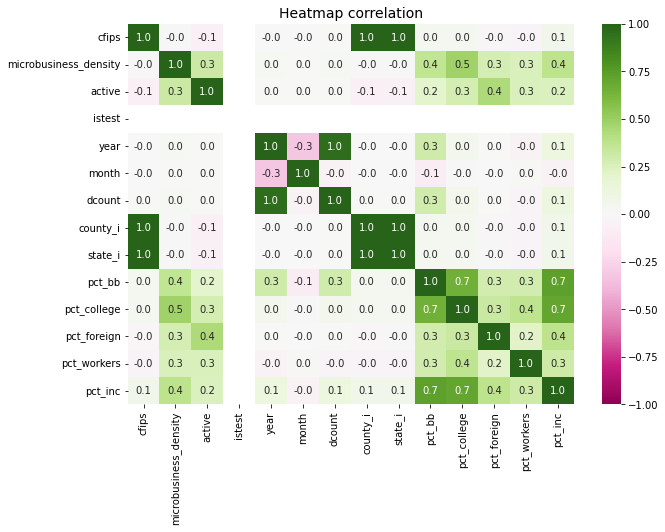

In [395]:
heatmap(df_all_train)

pep8(_ih)

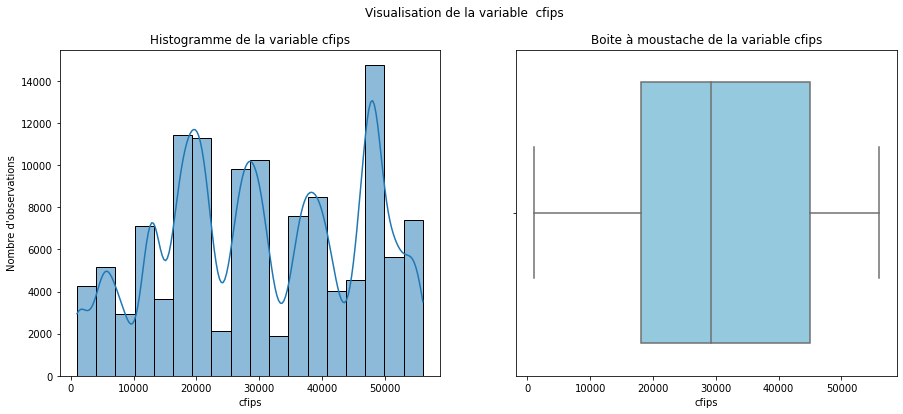

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      30376.037640
std       15143.508721
min        1001.000000
25%       18177.000000
50%       29173.000000
75%       45077.000000
max       56045.000000
Name: cfips, dtype: float64


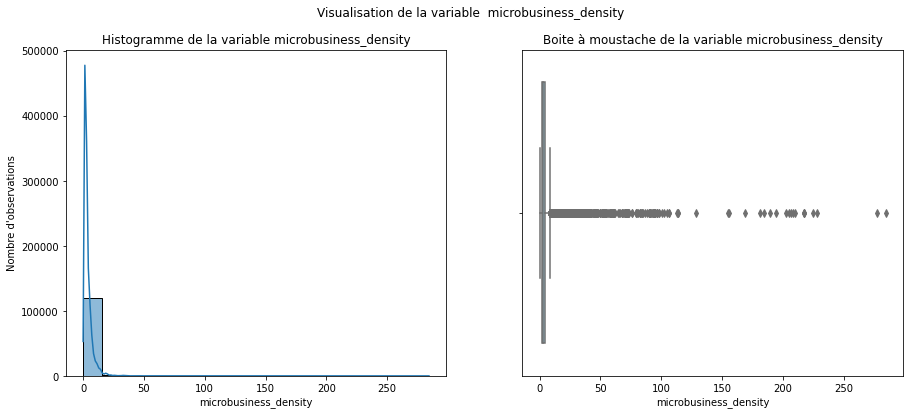

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64


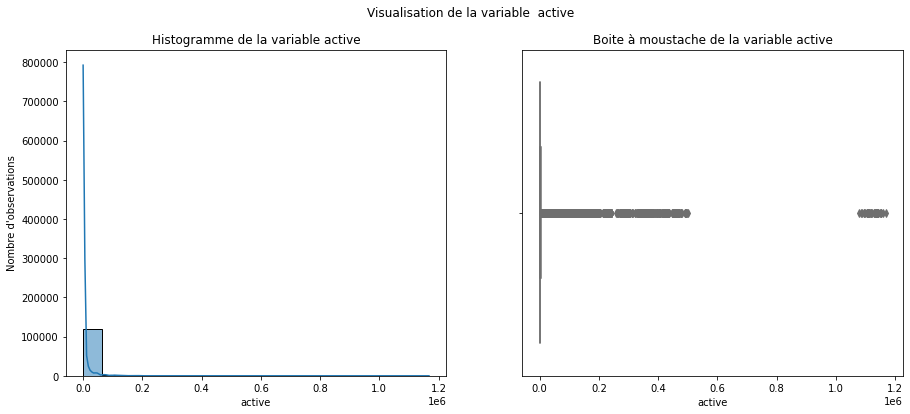

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    1.222650e+05
mean     6.442858e+03
std      3.304001e+04
min      0.000000e+00
25%      1.450000e+02
50%      4.880000e+02
75%      2.124000e+03
max      1.167744e+06
Name: active, dtype: float64


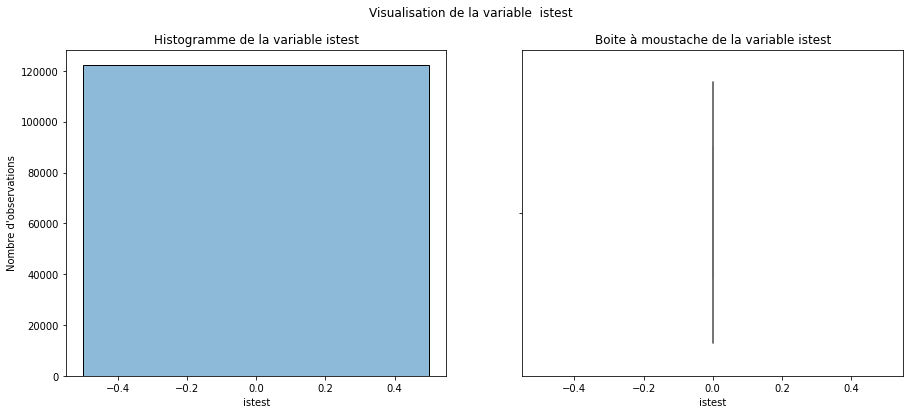

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: istest, dtype: float64


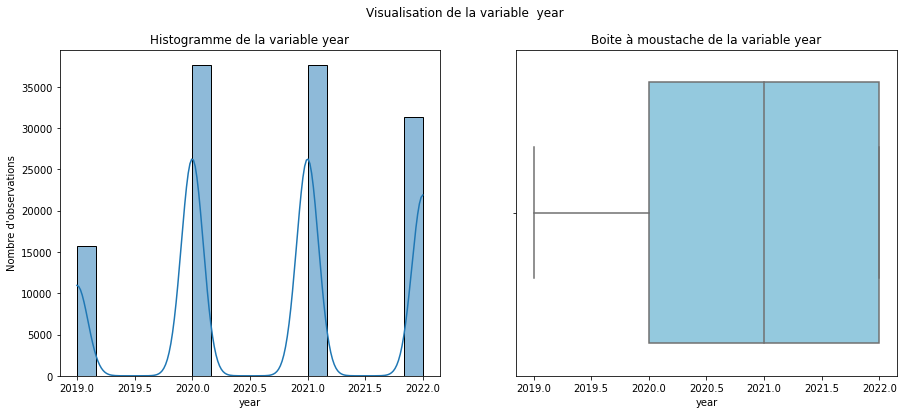

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       2020.692308
std           0.991089
min        2019.000000
25%        2020.000000
50%        2021.000000
75%        2022.000000
max        2022.000000
Name: year, dtype: float64


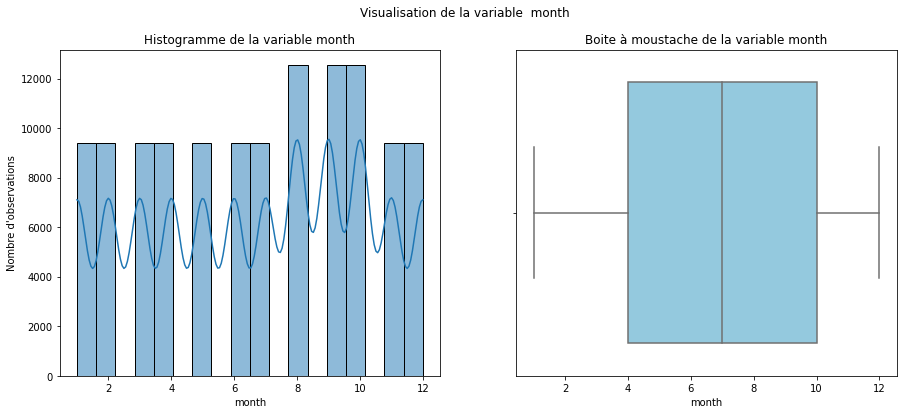

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          6.692308
std           3.390452
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64


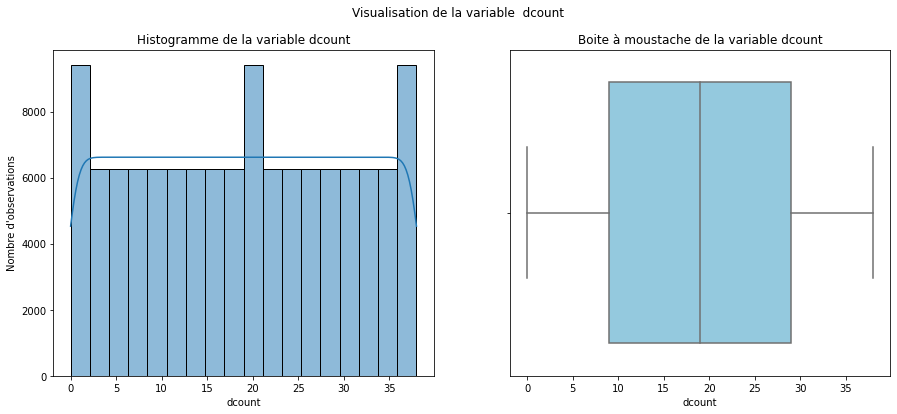

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         19.000000
std          11.254675
min           0.000000
25%           9.000000
50%          19.000000
75%          29.000000
max          38.000000
Name: dcount, dtype: float64


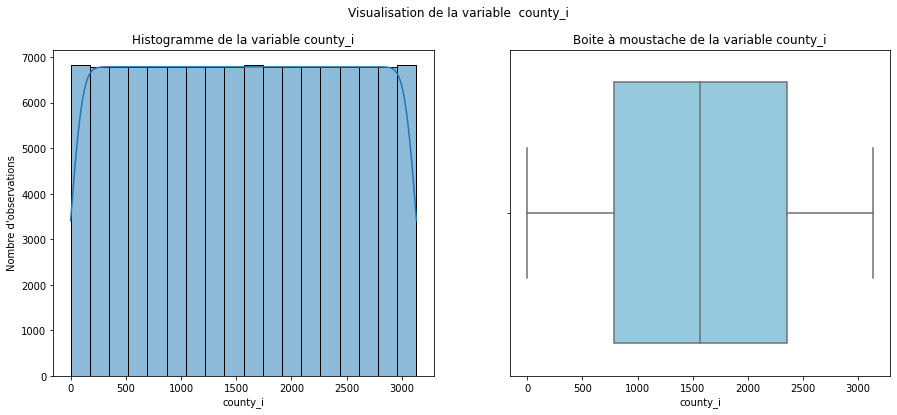

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1567.000000
std         905.000202
min           0.000000
25%         783.000000
50%        1567.000000
75%        2351.000000
max        3134.000000
Name: county_i, dtype: float64


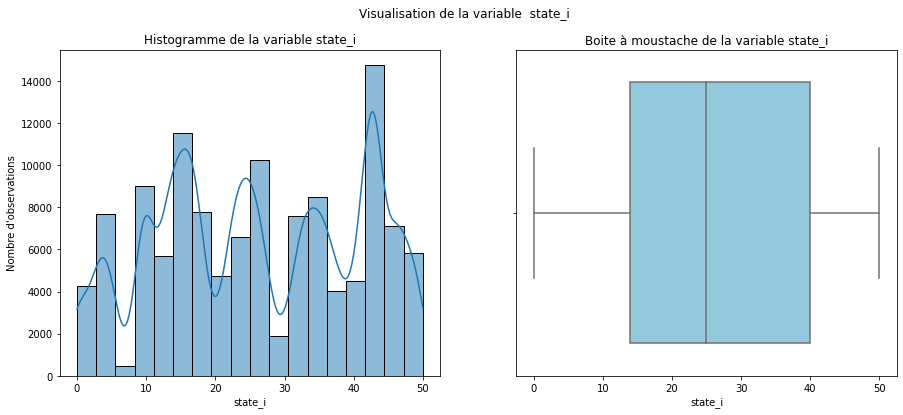

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         26.229665
std          14.253994
min           0.000000
25%          14.000000
50%          25.000000
75%          40.000000
max          50.000000
Name: state_i, dtype: float64


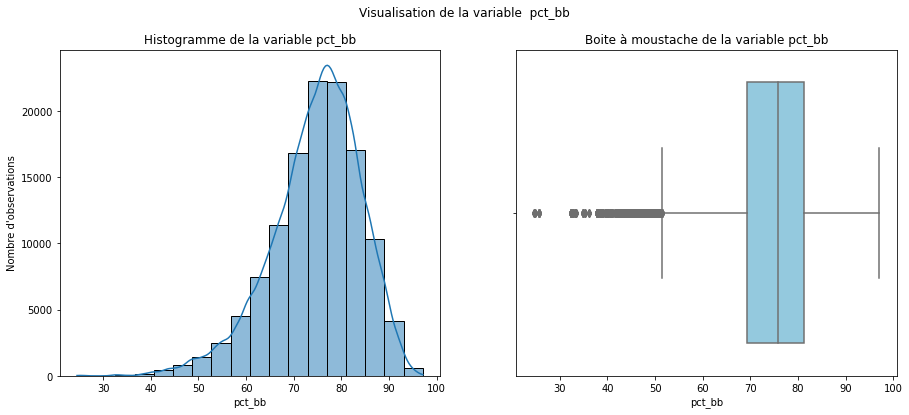

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         74.686369
std           9.374487
min          24.500000
25%          69.300000
50%          75.800000
75%          81.200000
max          97.100000
Name: pct_bb, dtype: float64


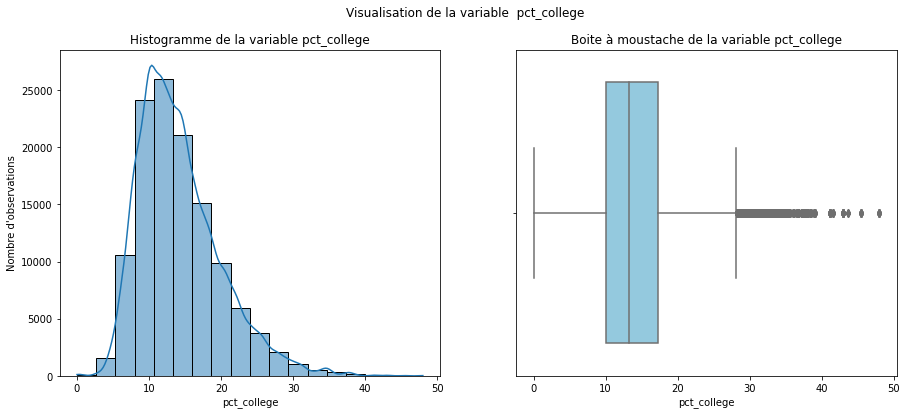

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         14.220153
std           5.685812
min           0.000000
25%          10.100000
50%          13.200000
75%          17.300000
max          48.000000
Name: pct_college, dtype: float64


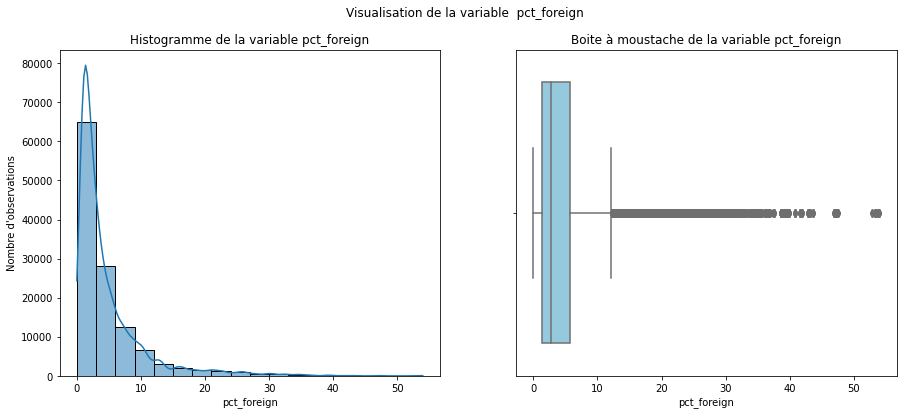

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          4.744932
std           5.711121
min           0.000000
25%           1.400000
50%           2.700000
75%           5.700000
max          54.000000
Name: pct_foreign, dtype: float64


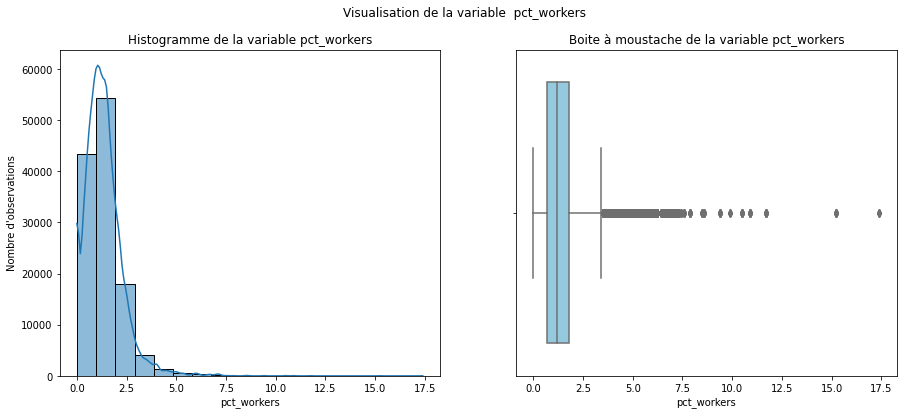

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          1.355777
std           0.960013
min           0.000000
25%           0.700000
50%           1.200000
75%           1.800000
max          17.400000
Name: pct_workers, dtype: float64


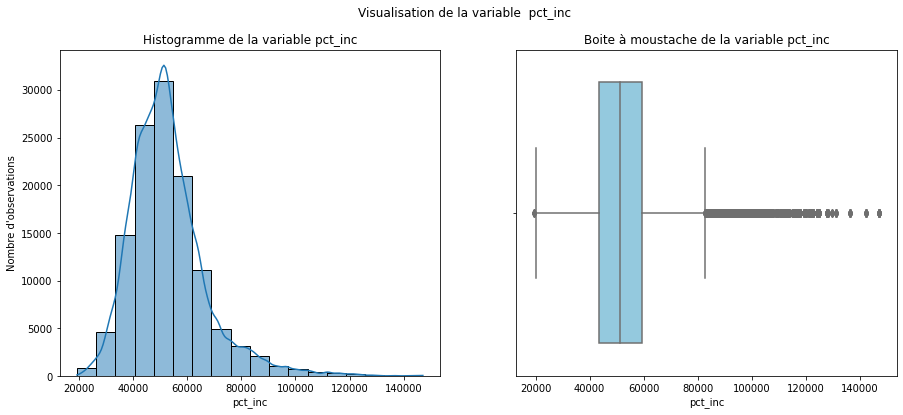

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      52830.468850
std       14129.478137
min       19264.000000
25%       43507.000000
50%       51097.000000
75%       59230.000000
max      147111.000000
Name: pct_inc, dtype: float64



In [396]:
for col in df_all_train.select_dtypes(include=['float64', 'int64']):
    hist_box_plot(df_all_train,
                  col,
                  subtitle=f"Visualisation de la variable  {col}",
                  hist_title=f'Histogramme de la variable {col}',
                  color='skyblue')

pep8(_ih)

##Log microbusiness density

In [397]:
df_all_train['microbusiness_density_log'] = np.log(df_all_train
                                                   ["microbusiness_density"])

pep8(_ih)

##Viz microbusiness_density_log

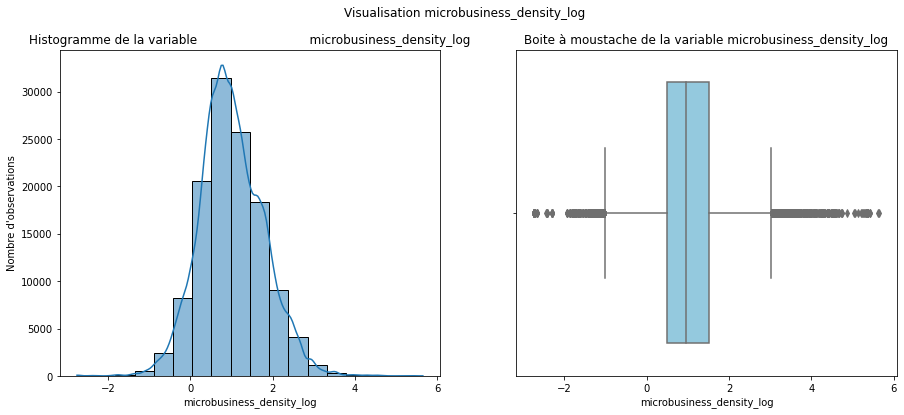

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    1.222650e+05
mean             -inf
std               NaN
min              -inf
25%      4.942963e-01
50%      9.503224e-01
75%      1.508342e+00
max      5.650171e+00
Name: microbusiness_density_log, dtype: float64



In [398]:
hist_box_plot(df_all_train,
              col="microbusiness_density_log",
              subtitle="Visualisation microbusiness_density_log",
              hist_title='Histogramme de la variable \
                            microbusiness_density_log',
              color='skyblue')

pep8(_ih)

##Log active

In [399]:
df_all_train['active_log'] = np.log(df_all_train["active"])

pep8(_ih)

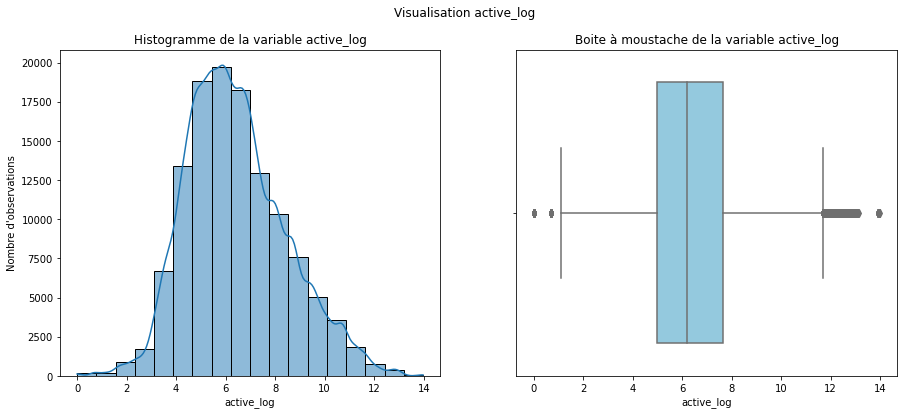

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    1.222650e+05
mean             -inf
std               NaN
min              -inf
25%      4.976734e+00
50%      6.190315e+00
75%      7.661056e+00
max      1.397058e+01
Name: active_log, dtype: float64



In [400]:
hist_box_plot(df_all_train,
              col="active_log",
              subtitle="Visualisation active_log",
              hist_title='Histogramme de la variable active_log',
              color='skyblue')

pep8(_ih)

#Outliers

##dataframe df_train_smoothy

In [401]:
df_train_to_smooth = df_all_train.copy(deep=True)

pep8(_ih)

In [402]:
lst1 = df_train_to_smooth.columns[5:7].tolist()
lst2 = df_train_to_smooth.columns[13:19].tolist()
lst = lst1+lst2

pep8(_ih)

In [403]:
col_census = lst
df_train_smoothy = smooth(df_train_to_smooth,
                          coln=col_census)
df_train_smoothy.head(3)

pep8(_ih)

##Viz df train smoothy

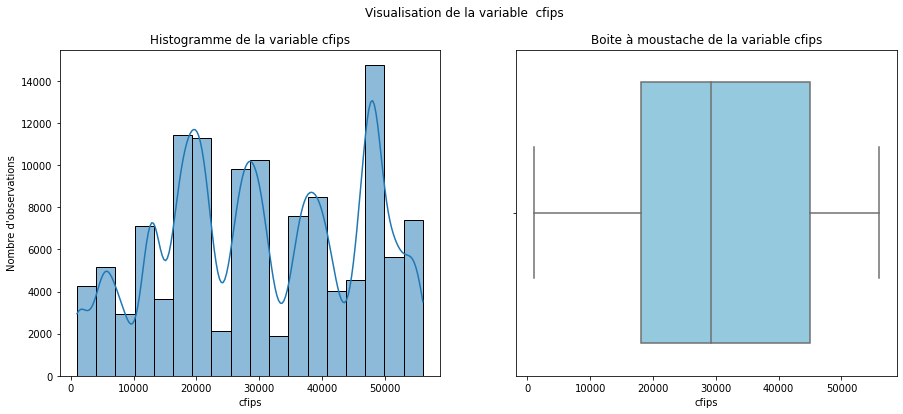

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      30376.037640
std       15143.508721
min        1001.000000
25%       18177.000000
50%       29173.000000
75%       45077.000000
max       56045.000000
Name: cfips, dtype: float64


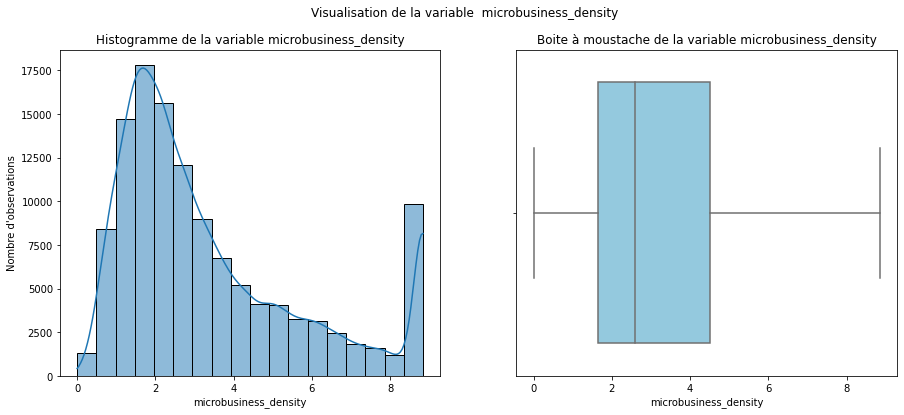

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.378144
std           2.349475
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max           8.839061
Name: microbusiness_density, dtype: float64


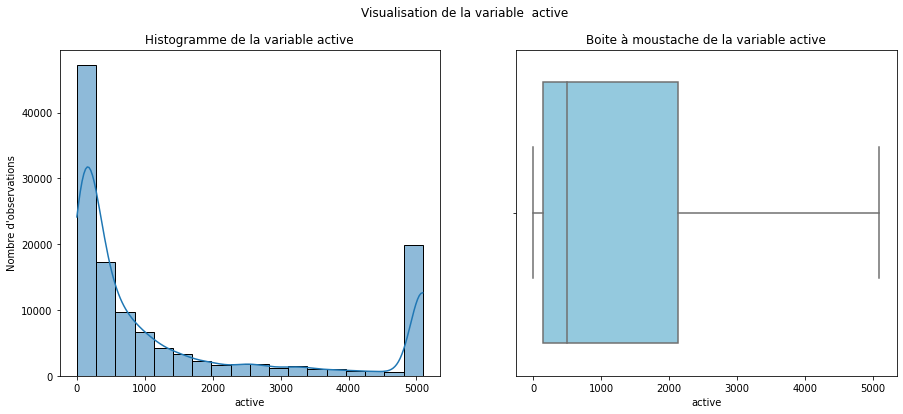

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1455.818251
std        1835.466134
min           0.000000
25%         145.000000
50%         488.000000
75%        2124.000000
max        5092.500000
Name: active, dtype: float64


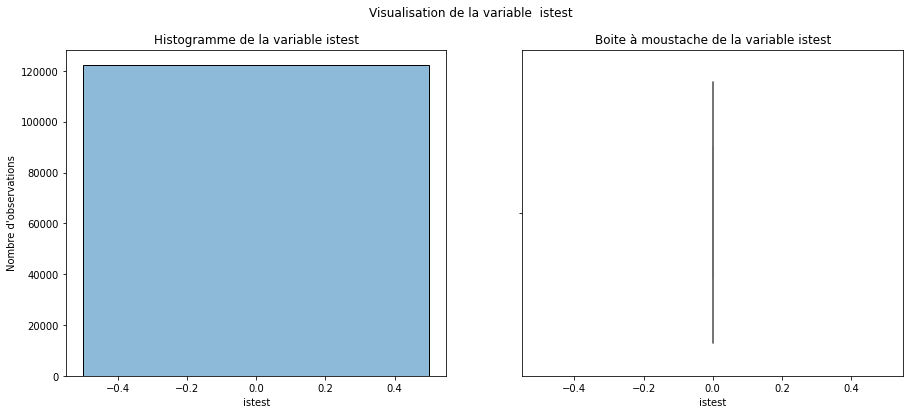

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: istest, dtype: float64


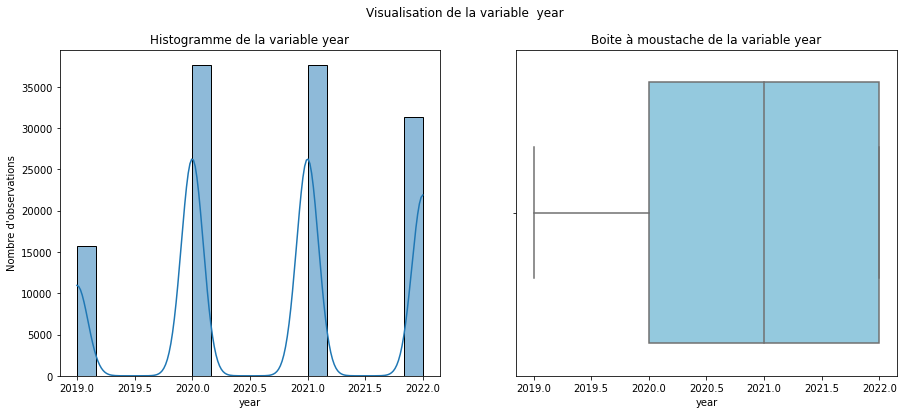

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       2020.692308
std           0.991089
min        2019.000000
25%        2020.000000
50%        2021.000000
75%        2022.000000
max        2022.000000
Name: year, dtype: float64


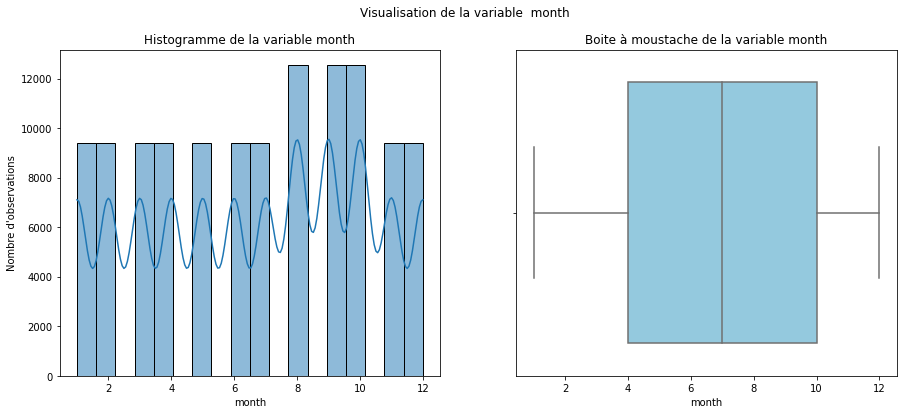

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          6.692308
std           3.390452
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64


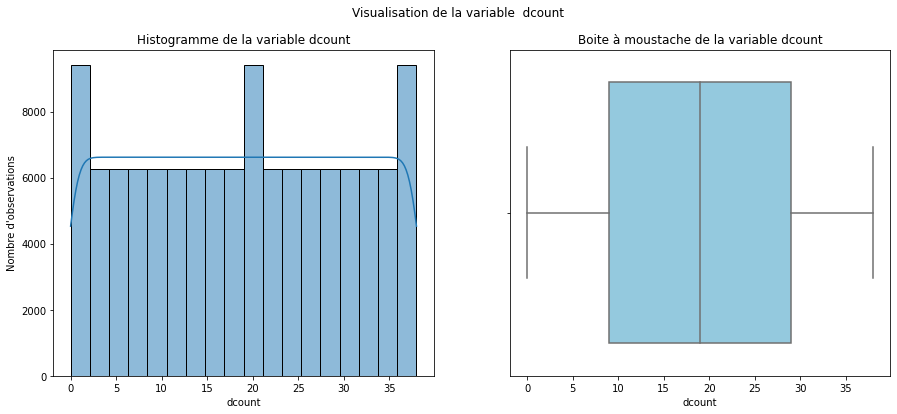

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         19.000000
std          11.254675
min           0.000000
25%           9.000000
50%          19.000000
75%          29.000000
max          38.000000
Name: dcount, dtype: float64


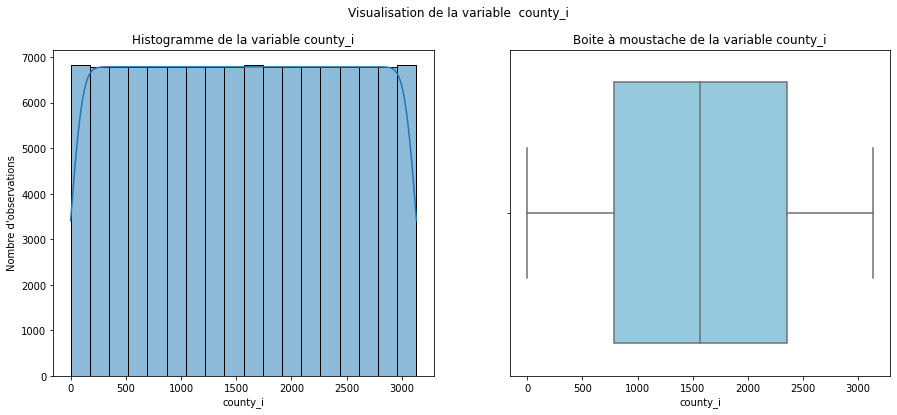

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1567.000000
std         905.000202
min           0.000000
25%         783.000000
50%        1567.000000
75%        2351.000000
max        3134.000000
Name: county_i, dtype: float64


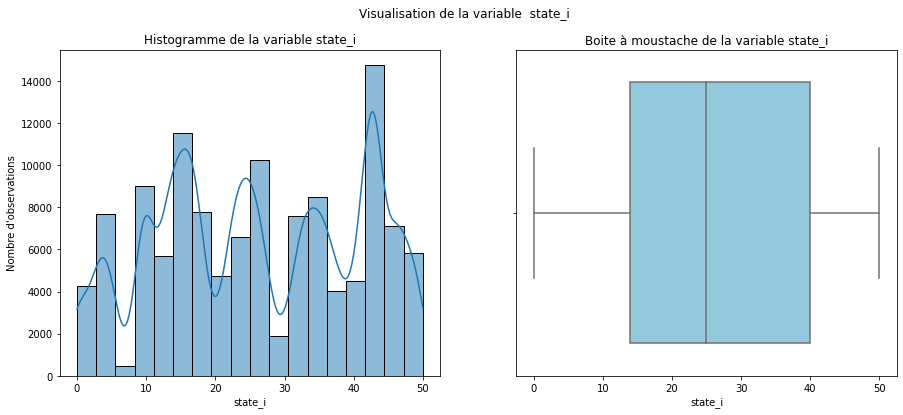

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         26.229665
std          14.253994
min           0.000000
25%          14.000000
50%          25.000000
75%          40.000000
max          50.000000
Name: state_i, dtype: float64


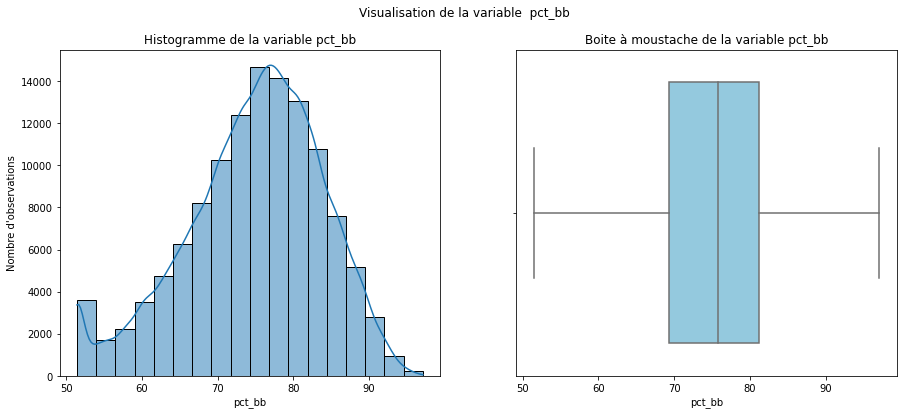

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         74.788855
std           9.064733
min          51.450000
25%          69.300000
50%          75.800000
75%          81.200000
max          97.100000
Name: pct_bb, dtype: float64


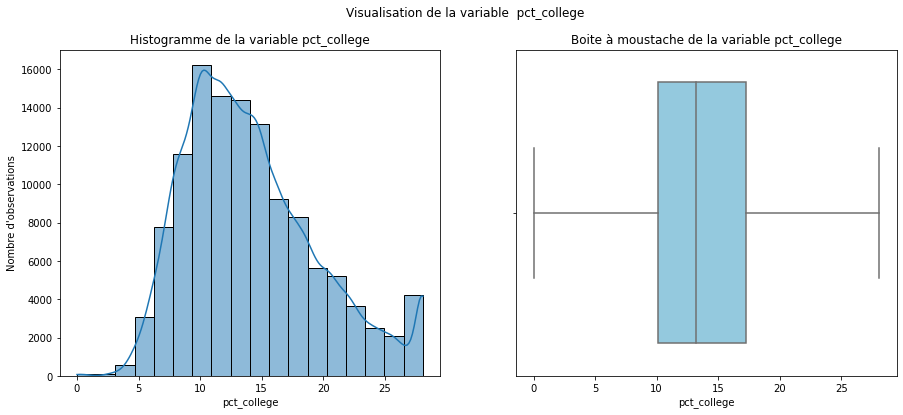

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.00000
mean         14.13029
std           5.40431
min           0.00000
25%          10.10000
50%          13.20000
75%          17.30000
max          28.10000
Name: pct_college, dtype: float64


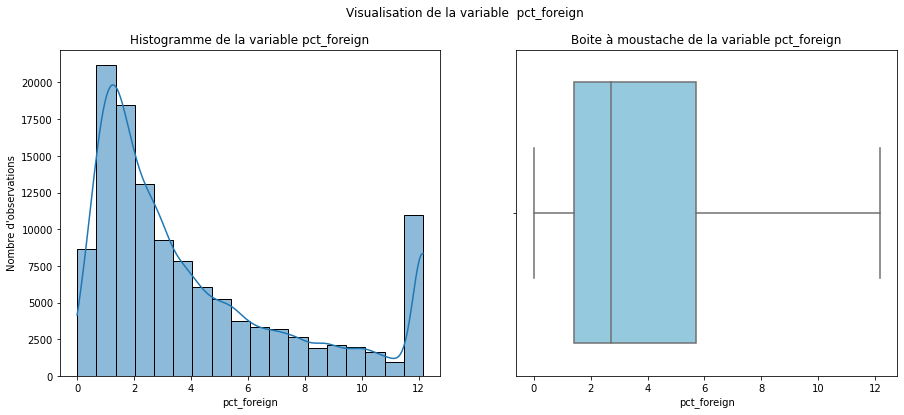

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          4.080285
std           3.561062
min           0.000000
25%           1.400000
50%           2.700000
75%           5.700000
max          12.150000
Name: pct_foreign, dtype: float64


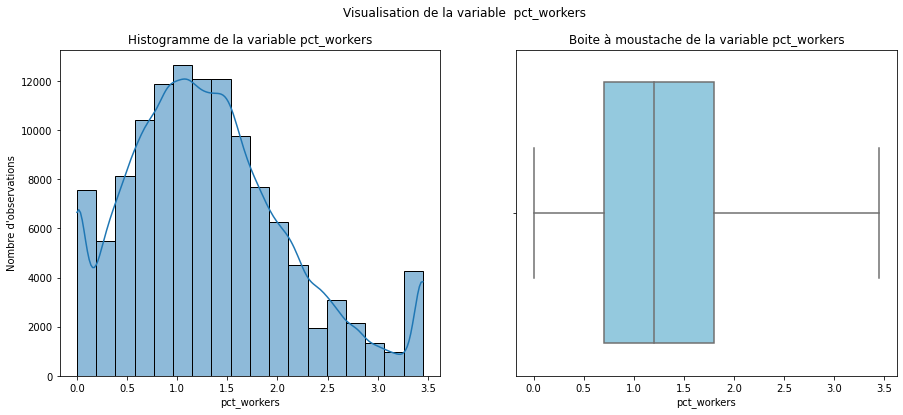

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          1.320209
std           0.815275
min           0.000000
25%           0.700000
50%           1.200000
75%           1.800000
max           3.450000
Name: pct_workers, dtype: float64


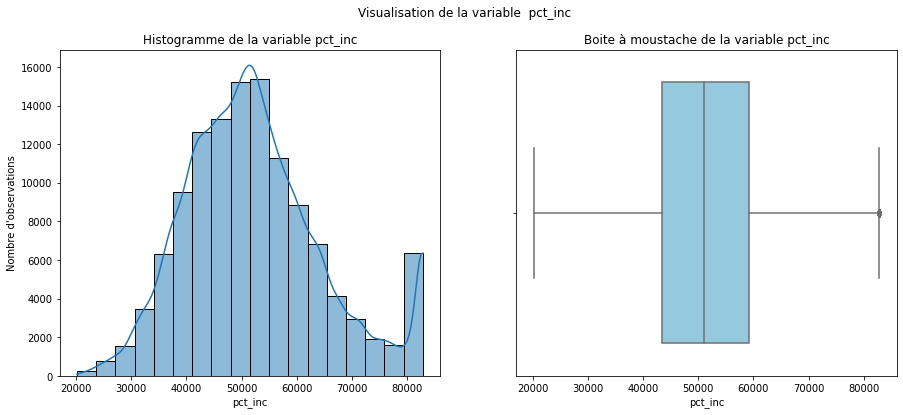

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      52330.531644
std       12544.911912
min       20188.000000
25%       43512.000000
50%       51097.000000
75%       59230.000000
max       82814.500000
Name: pct_inc, dtype: float64


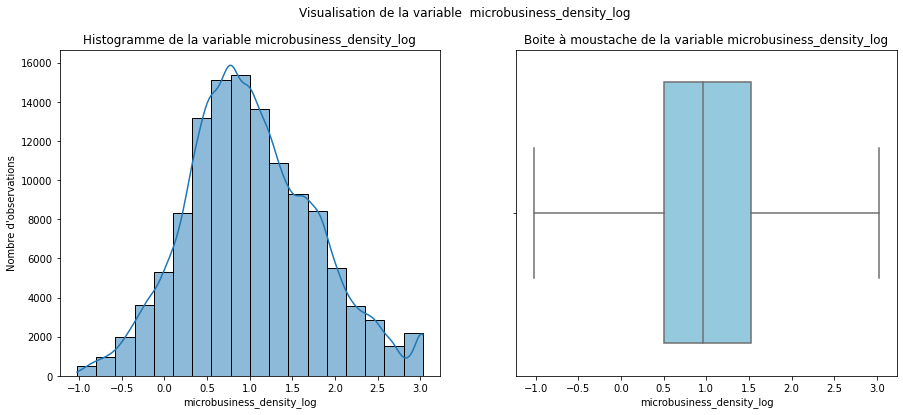

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          1.020345
std           0.759560
min          -1.024642
25%           0.501808
50%           0.957612
75%           1.520416
max           3.029410
Name: microbusiness_density_log, dtype: float64


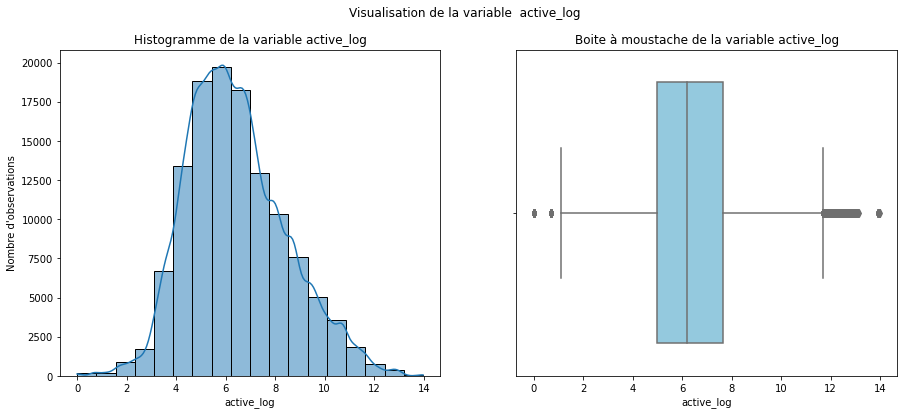

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    1.222650e+05
mean             -inf
std               NaN
min              -inf
25%      4.976734e+00
50%      6.190315e+00
75%      7.661056e+00
max      1.397058e+01
Name: active_log, dtype: float64



In [682]:
for col in df_train_smoothy.select_dtypes(include=['float64', 'int64']):
    hist_box_plot(df_train_smoothy,
                  col,
                  subtitle=f"Visualisation de la variable  {col}",
                  hist_title=f'Histogramme de la variable {col}',
                  color='skyblue')

pep8(_ih)

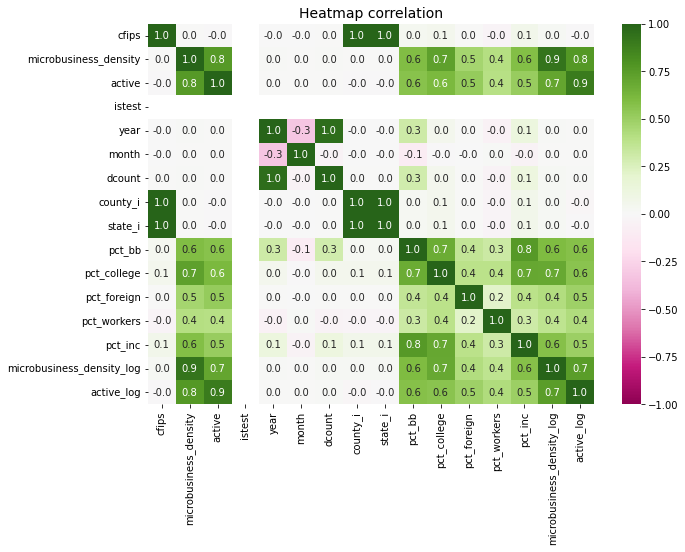

In [405]:
heatmap(df_train_smoothy)

pep8(_ih)

##Viz map

In [406]:
viz_map(df_train_smoothy, 'microbusiness_density')

pep8(_ih)

Output hidden; open in https://colab.research.google.com to view.

#Features engineering

##dataframe

In [407]:
df_train_smoothy_1 = df_train_smoothy.copy(deep=True)
df_train_smoothy_1.sort_values(by='first_day_of_month', ascending=False,
                               inplace=True)
df_train_smoothy_1.head(3)

pep8(_ih)

In [408]:
df_train_smoothy_2 = features(df_train_smoothy_1)
pep8(_ih)

##dataframe train with new features (median)

In [409]:
df_train_new_feat_smooth_3 = new_features1(df_train_smoothy_2,
                                           df_train_smoothy_2.columns[18:31])

pep8(_ih)

In [410]:
# df_train_new_feat_smooth = new_features2(df_train_new_feat_smooth_2)
df_train_new_feat_smooth = new_features2(df_train_new_feat_smooth_3)

pep8(_ih)

In [411]:
df_train_new_feat_smooth.isna().sum()

pep8(_ih)

In [412]:
df_train_new_feat_smooth.describe()

pep8(_ih)

##Viz

In [413]:
df_train_new_feat_smooth["log_dif_1"] = np.log(df_train_new_feat_smooth
                                               ["dif_1"])

pep8(_ih)

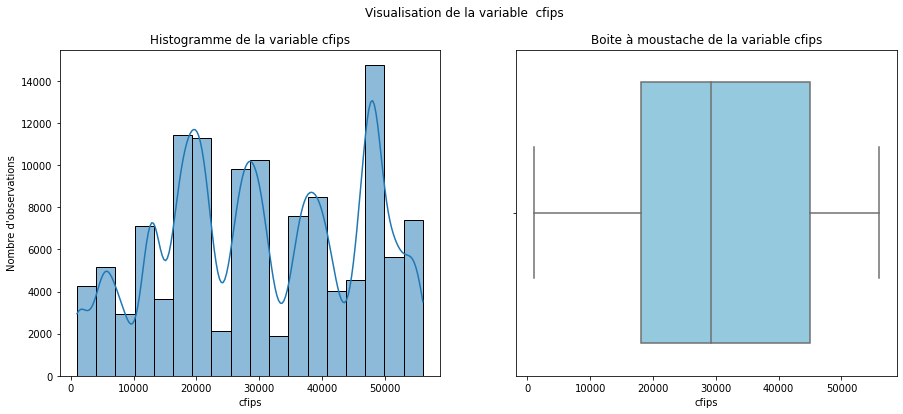

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      30376.037640
std       15143.508721
min        1001.000000
25%       18177.000000
50%       29173.000000
75%       45077.000000
max       56045.000000
Name: cfips, dtype: float64


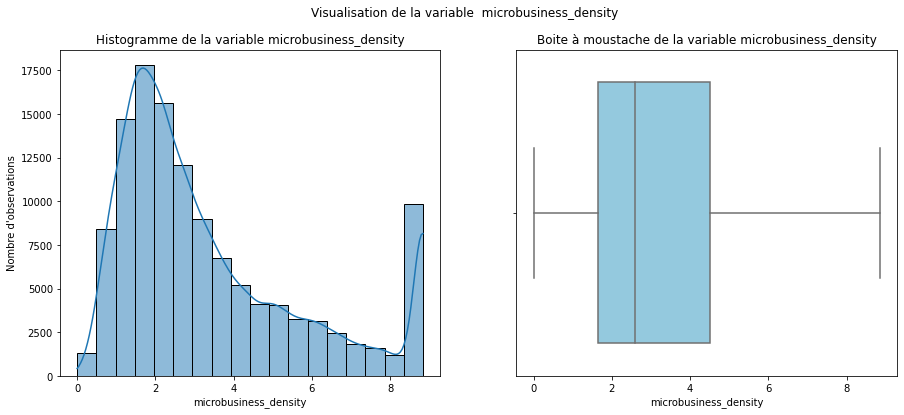

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.378144
std           2.349475
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max           8.839061
Name: microbusiness_density, dtype: float64


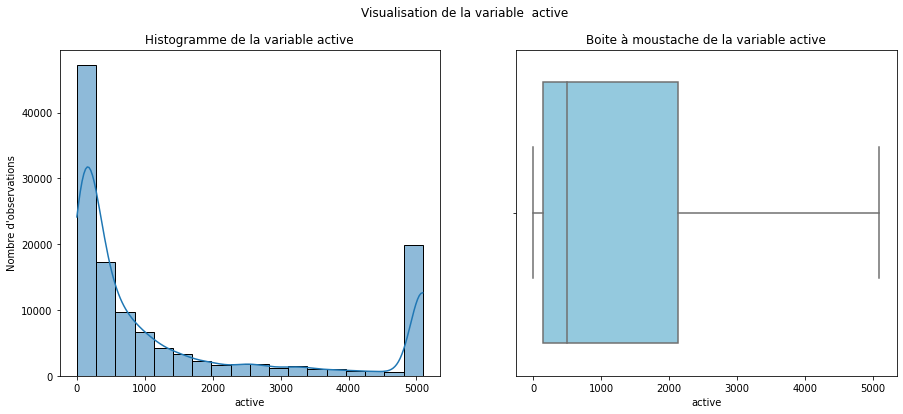

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1455.818251
std        1835.466134
min           0.000000
25%         145.000000
50%         488.000000
75%        2124.000000
max        5092.500000
Name: active, dtype: float64


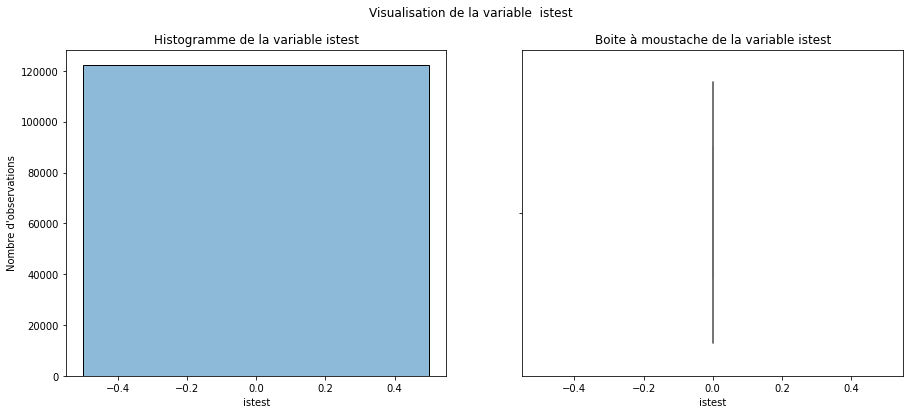

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: istest, dtype: float64


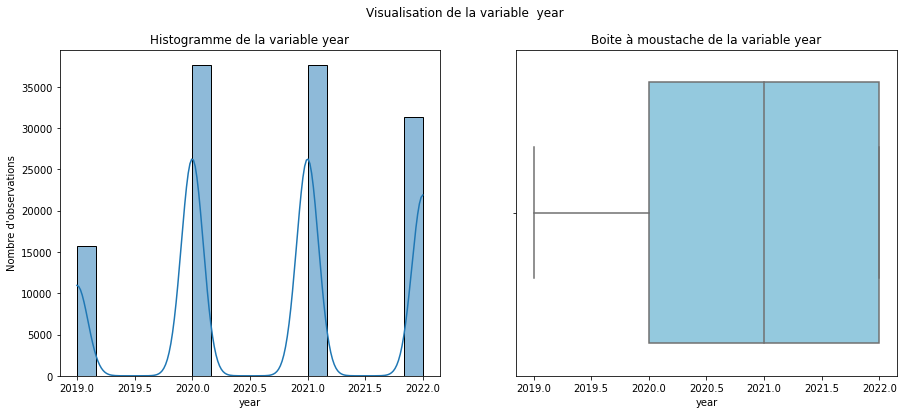

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       2020.692308
std           0.991089
min        2019.000000
25%        2020.000000
50%        2021.000000
75%        2022.000000
max        2022.000000
Name: year, dtype: float64


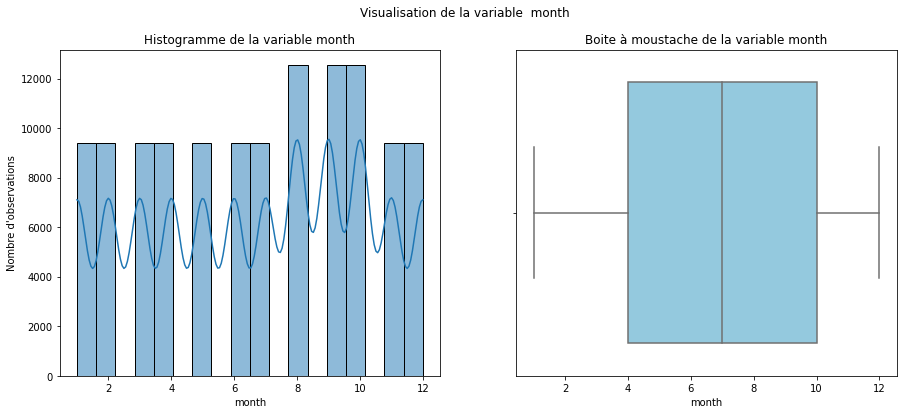

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          6.692308
std           3.390452
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: month, dtype: float64


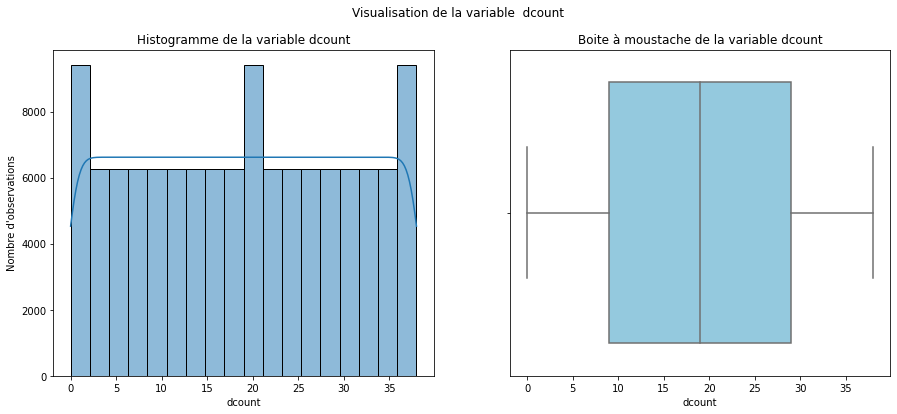

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         19.000000
std          11.254675
min           0.000000
25%           9.000000
50%          19.000000
75%          29.000000
max          38.000000
Name: dcount, dtype: float64


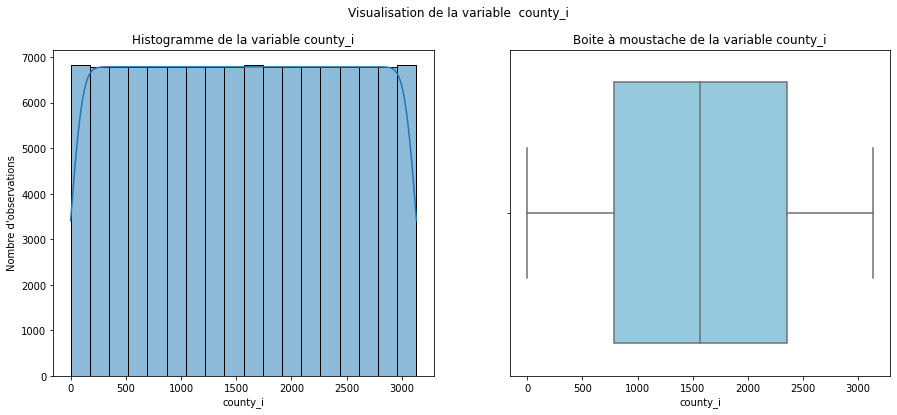

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean       1567.000000
std         905.000202
min           0.000000
25%         783.000000
50%        1567.000000
75%        2351.000000
max        3134.000000
Name: county_i, dtype: float64


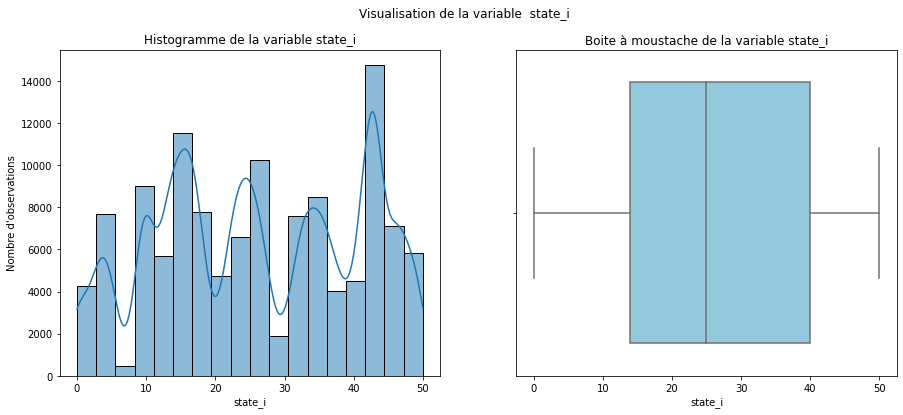

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         26.229665
std          14.253994
min           0.000000
25%          14.000000
50%          25.000000
75%          40.000000
max          50.000000
Name: state_i, dtype: float64


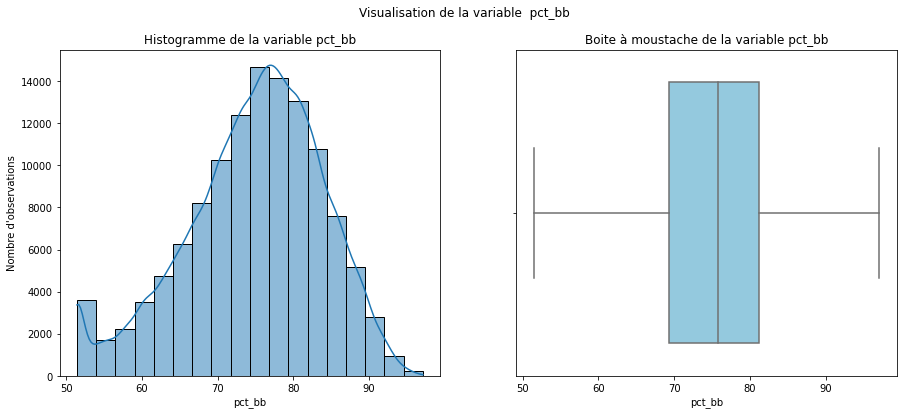

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         74.788855
std           9.064733
min          51.450000
25%          69.300000
50%          75.800000
75%          81.200000
max          97.100000
Name: pct_bb, dtype: float64


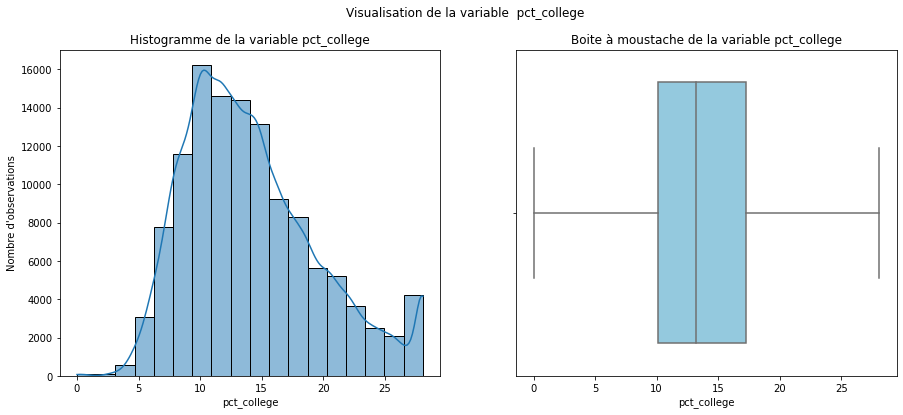

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.00000
mean         14.13029
std           5.40431
min           0.00000
25%          10.10000
50%          13.20000
75%          17.30000
max          28.10000
Name: pct_college, dtype: float64


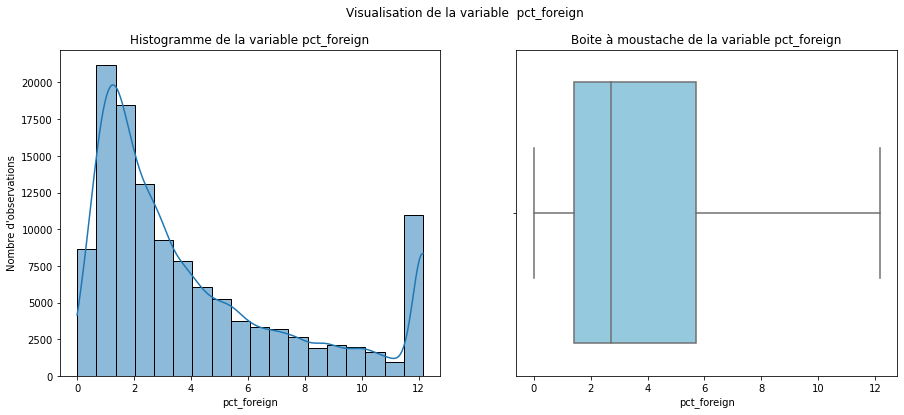

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          4.080285
std           3.561062
min           0.000000
25%           1.400000
50%           2.700000
75%           5.700000
max          12.150000
Name: pct_foreign, dtype: float64


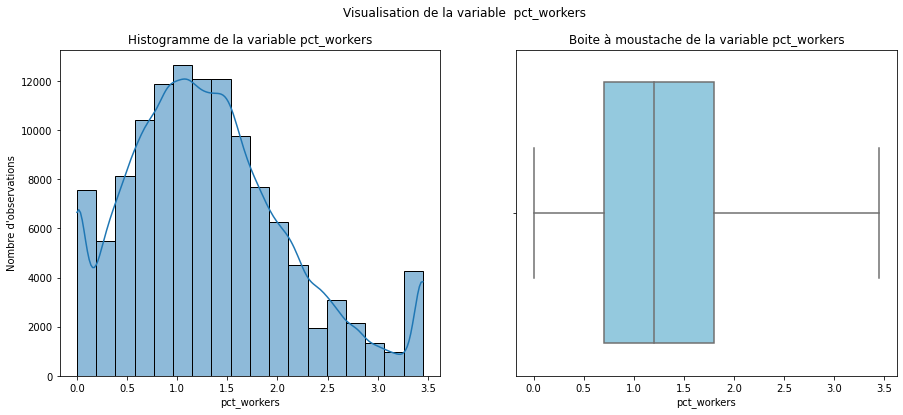

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          1.320209
std           0.815275
min           0.000000
25%           0.700000
50%           1.200000
75%           1.800000
max           3.450000
Name: pct_workers, dtype: float64


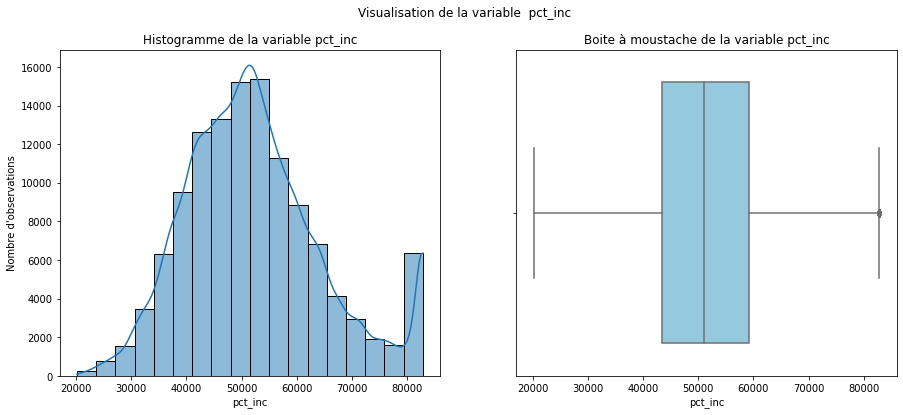

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean      52330.531644
std       12544.911912
min       20188.000000
25%       43512.000000
50%       51097.000000
75%       59230.000000
max       82814.500000
Name: pct_inc, dtype: float64


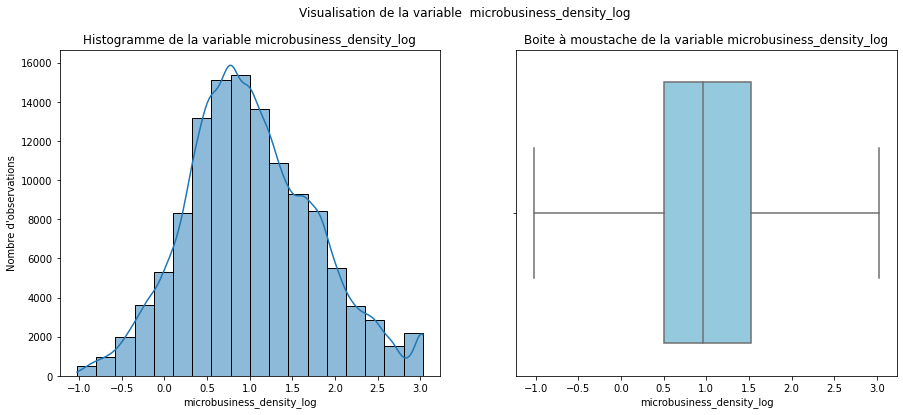

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          1.020345
std           0.759560
min          -1.024642
25%           0.501808
50%           0.957612
75%           1.520416
max           3.029410
Name: microbusiness_density_log, dtype: float64


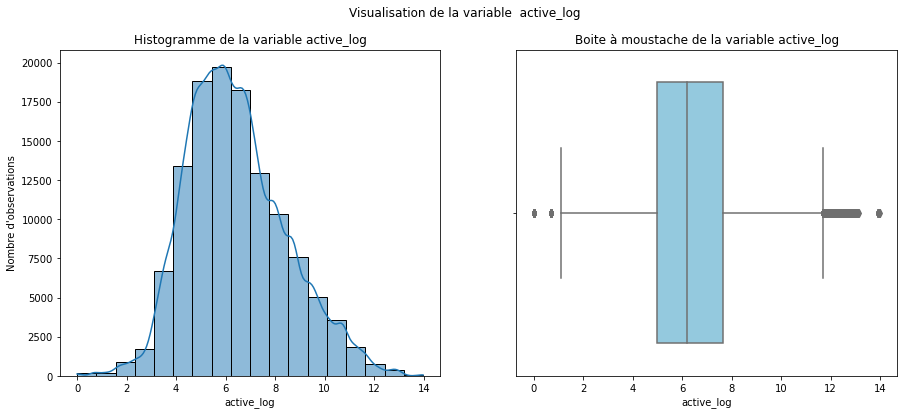

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    1.222650e+05
mean             -inf
std               NaN
min              -inf
25%      4.976734e+00
50%      6.190315e+00
75%      7.661056e+00
max      1.397058e+01
Name: active_log, dtype: float64


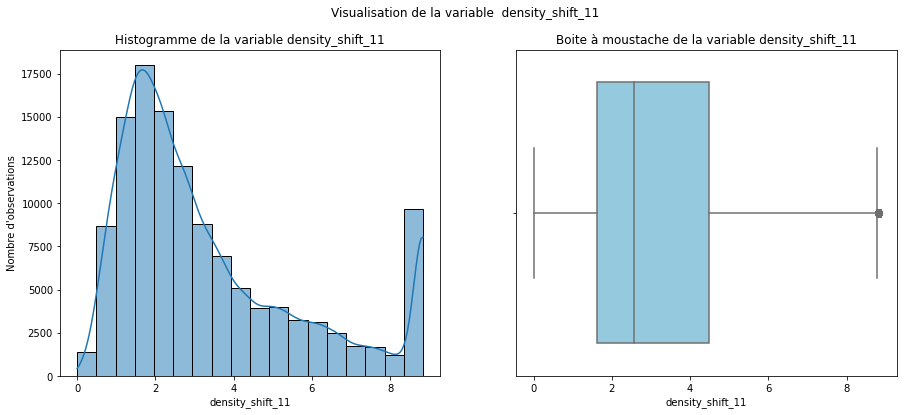

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.355515
std           2.348094
min           0.000000
25%           1.621836
50%           2.571245
75%           4.478046
max           8.839061
Name: density_shift_11, dtype: float64


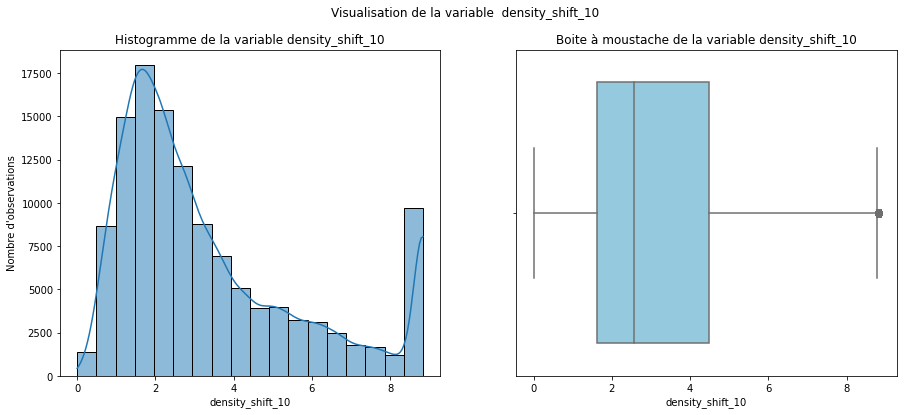

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.356379
std           2.348357
min           0.000000
25%           1.622740
50%           2.571138
75%           4.480519
max           8.839061
Name: density_shift_10, dtype: float64


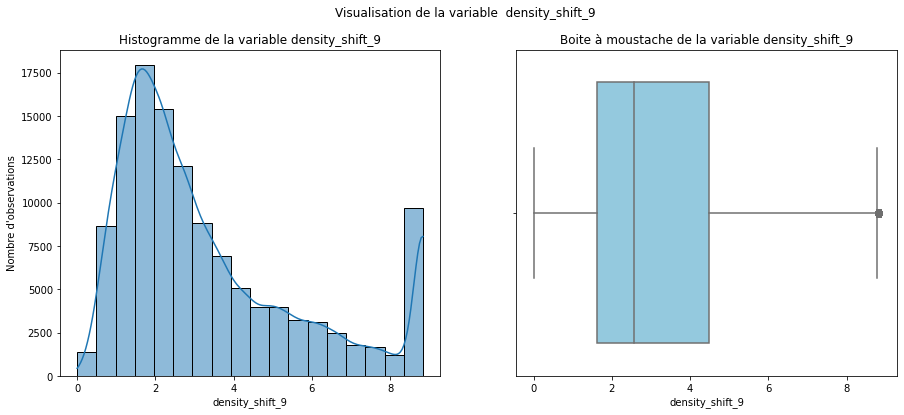

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.357034
std           2.348217
min           0.000000
25%           1.623599
50%           2.571039
75%           4.481617
max           8.839061
Name: density_shift_9, dtype: float64


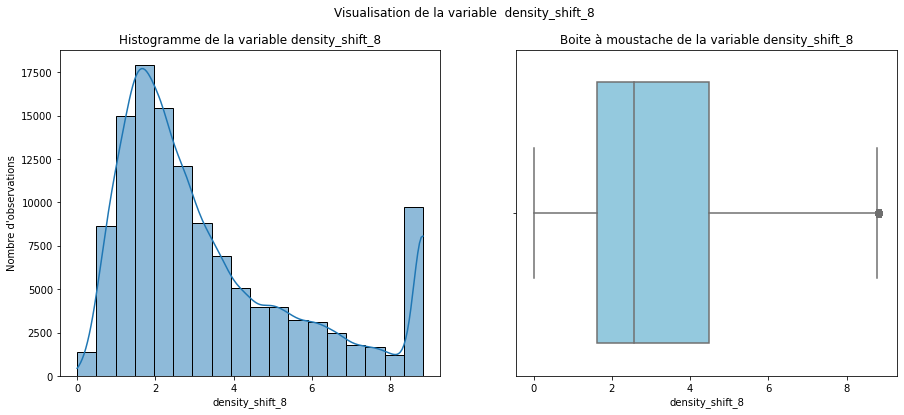

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.358077
std           2.348312
min           0.000000
25%           1.624815
50%           2.571717
75%           4.485050
max           8.839061
Name: density_shift_8, dtype: float64


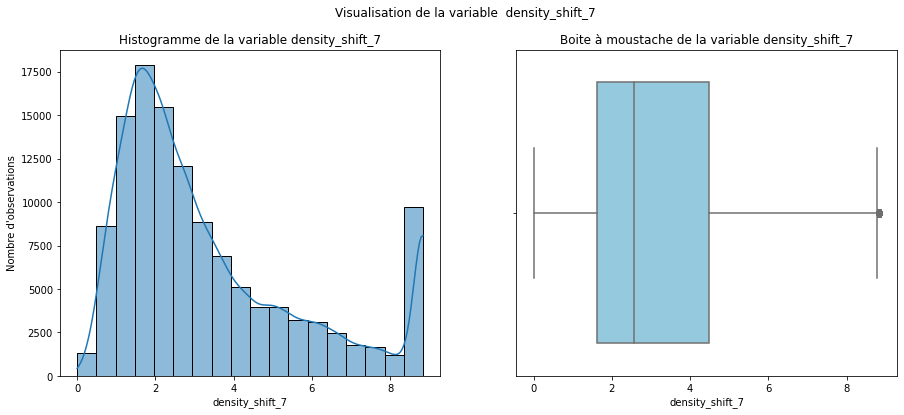

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.360748
std           2.348826
min           0.000000
25%           1.626141
50%           2.573371
75%           4.490528
max           8.839061
Name: density_shift_7, dtype: float64


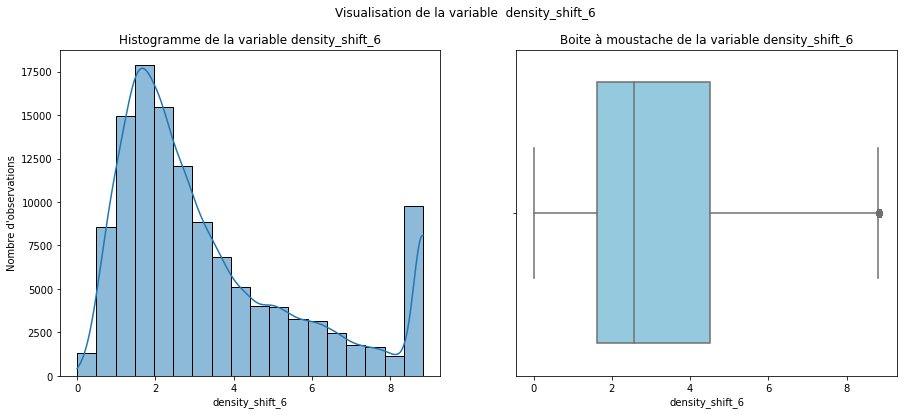

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.363513
std           2.349322
min           0.000000
25%           1.627907
50%           2.575540
75%           4.495019
max           8.839061
Name: density_shift_6, dtype: float64


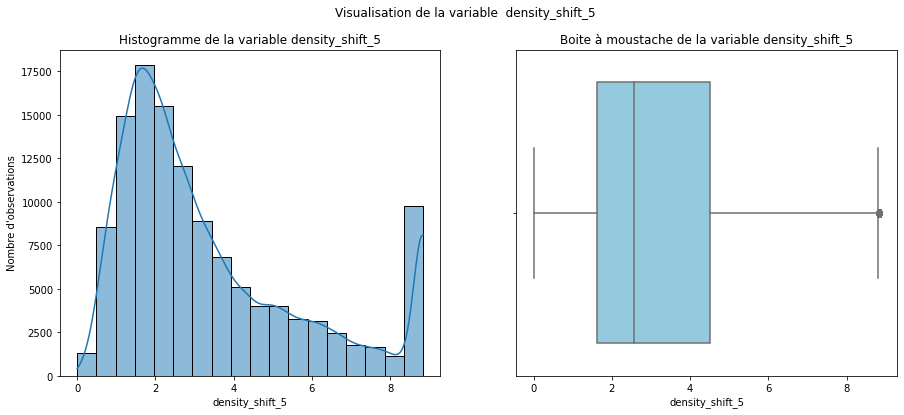

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.365023
std           2.349250
min           0.000000
25%           1.629107
50%           2.575982
75%           4.498251
max           8.839061
Name: density_shift_5, dtype: float64


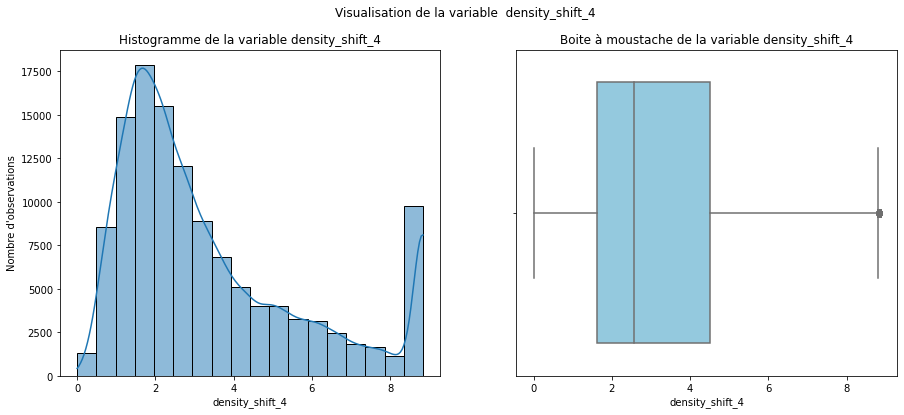

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.366537
std           2.349005
min           0.000000
25%           1.630667
50%           2.576951
75%           4.500802
max           8.839061
Name: density_shift_4, dtype: float64


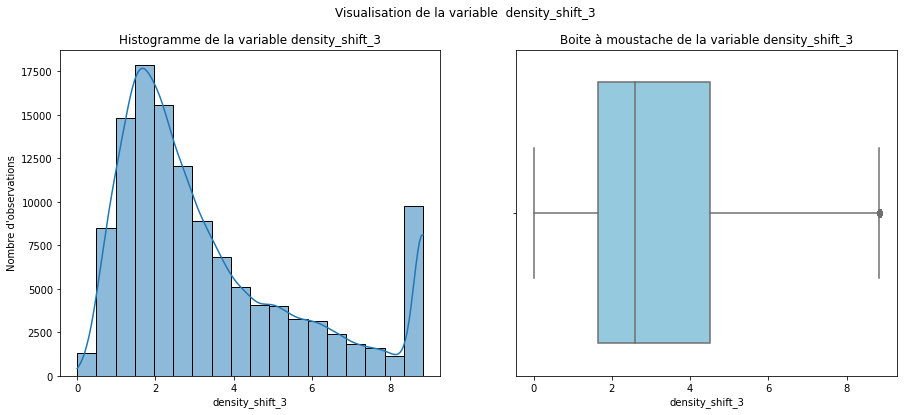

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.369155
std           2.348951
min           0.000000
25%           1.632784
50%           2.579097
75%           4.505426
max           8.839061
Name: density_shift_3, dtype: float64


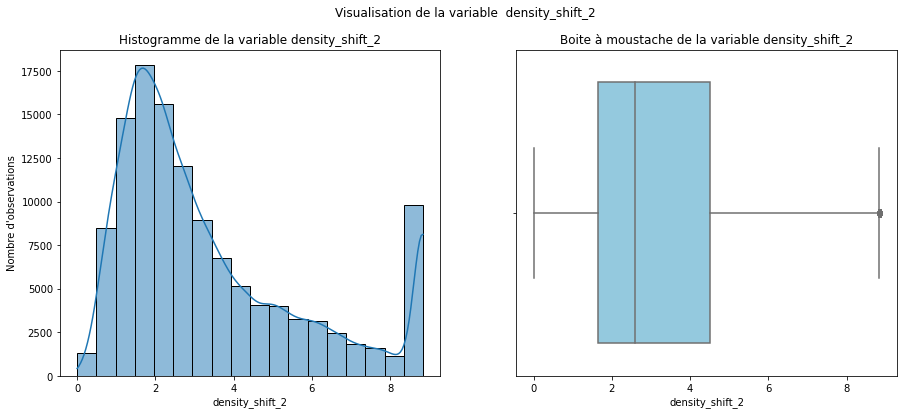

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.371809
std           2.348917
min           0.000000
25%           1.635020
50%           2.581411
75%           4.510027
max           8.839061
Name: density_shift_2, dtype: float64


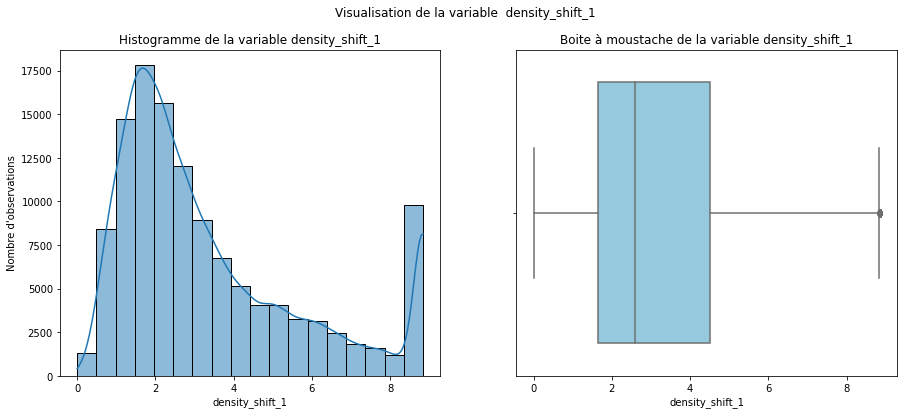

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean          3.374715
std           2.349014
min           0.000000
25%           1.636955
50%           2.583695
75%           4.514184
max           8.839061
Name: density_shift_1, dtype: float64


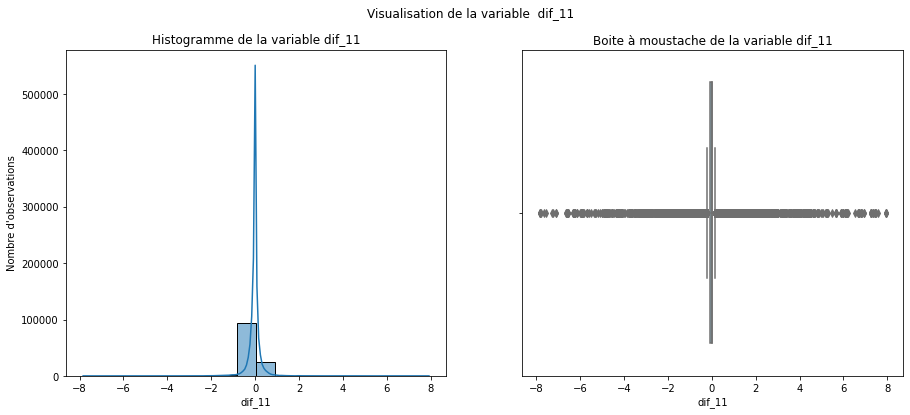

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.022629
std           0.391236
min          -7.839477
25%          -0.079560
50%           0.000000
75%           0.017665
max           7.919520
Name: dif_11, dtype: float64


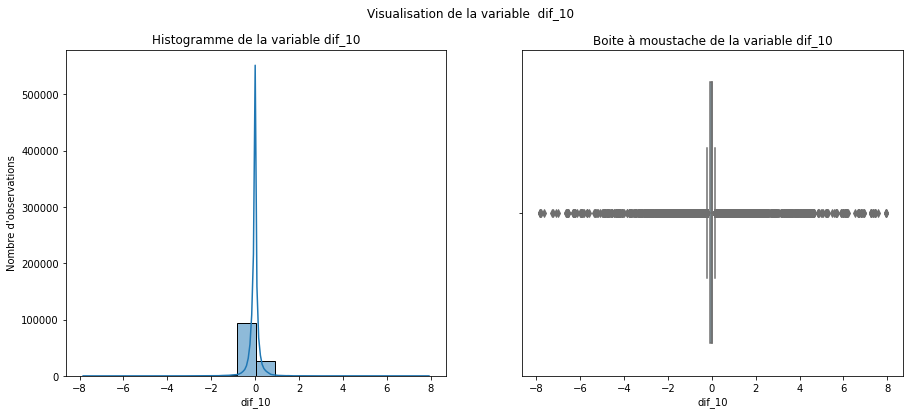

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.021765
std           0.381108
min          -7.839477
25%          -0.079681
50%           0.000000
75%           0.020478
max           7.919520
Name: dif_10, dtype: float64


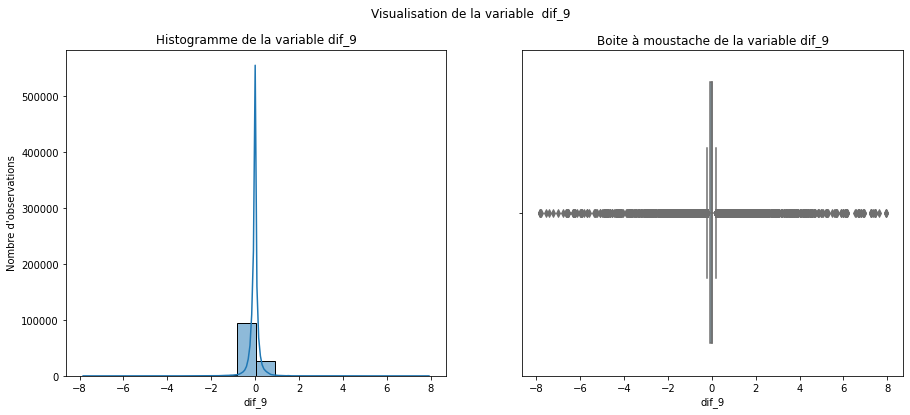

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.021110
std           0.368713
min          -7.839477
25%          -0.079137
50%           0.000000
75%           0.023234
max           7.919520
Name: dif_9, dtype: float64


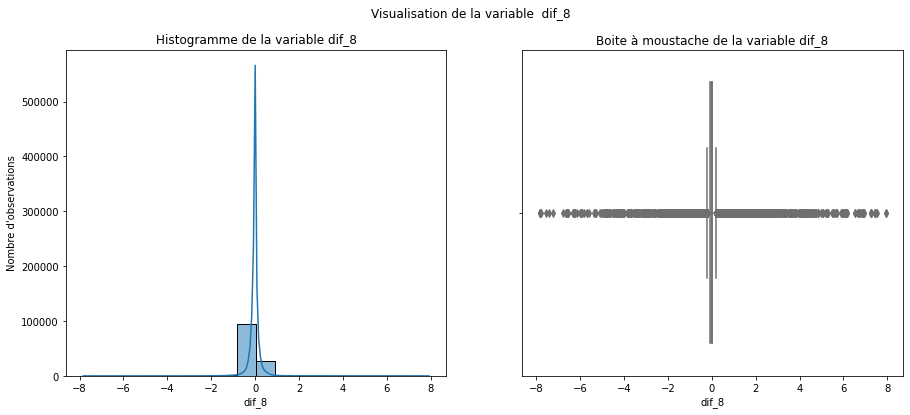

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.020067
std           0.354540
min          -7.839477
25%          -0.076594
50%           0.000000
75%           0.024983
max           7.919520
Name: dif_8, dtype: float64


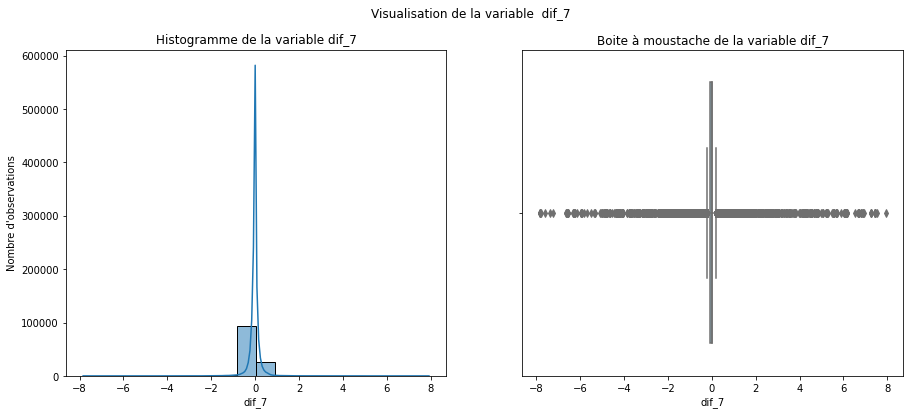

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.017396
std           0.337612
min          -7.839477
25%          -0.071657
50%           0.000000
75%           0.028313
max           7.919520
Name: dif_7, dtype: float64


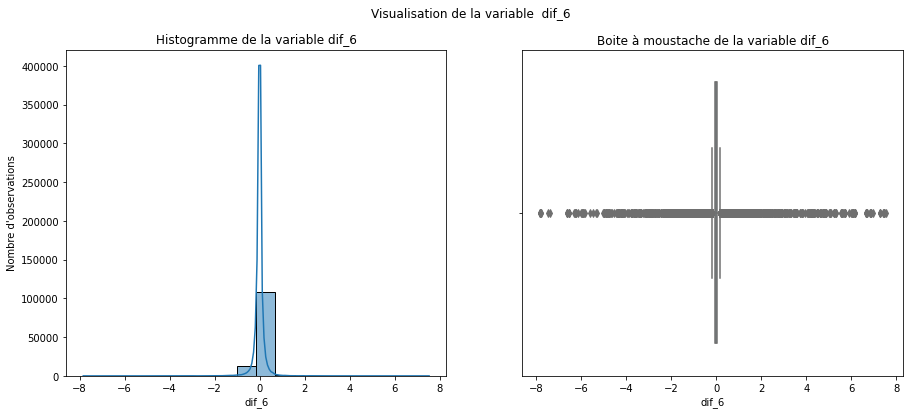

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.014631
std           0.318079
min          -7.839477
25%          -0.065570
50%           0.000000
75%           0.030886
max           7.522564
Name: dif_6, dtype: float64


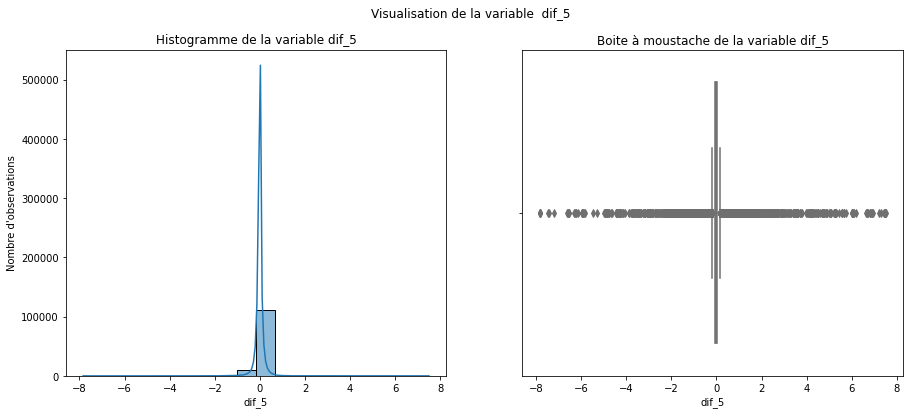

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.013120
std           0.295388
min          -7.839477
25%          -0.060719
50%           0.000000
75%           0.030546
max           7.495697
Name: dif_5, dtype: float64


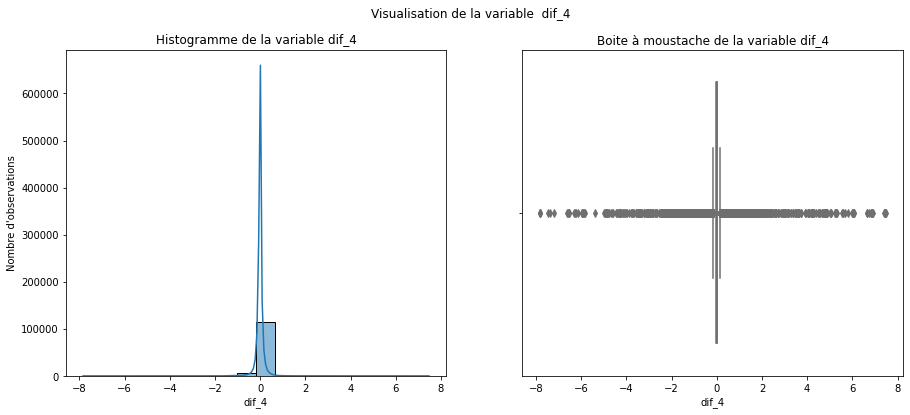

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.011607
std           0.268627
min          -7.839477
25%          -0.053549
50%           0.000000
75%           0.028358
max           7.468830
Name: dif_4, dtype: float64


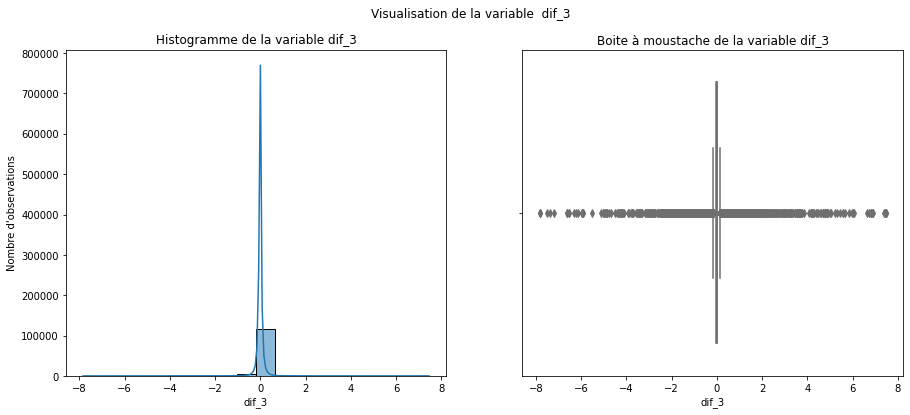

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.008989
std           0.236826
min          -7.839477
25%          -0.044749
50%           0.000000
75%           0.026121
max           7.459750
Name: dif_3, dtype: float64


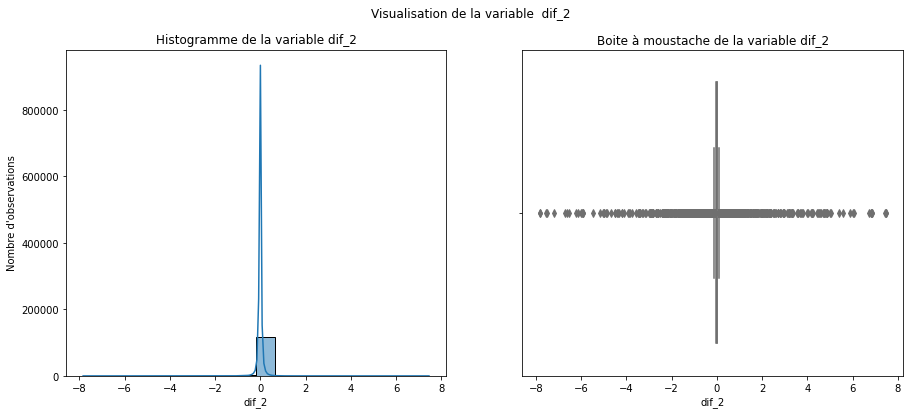

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.006335
std           0.198572
min          -7.839477
25%          -0.035114
50%           0.000000
75%           0.022629
max           7.459750
Name: dif_2, dtype: float64


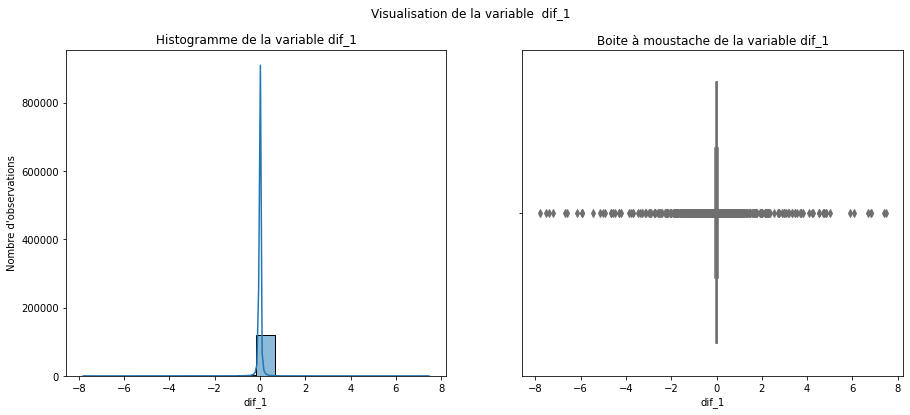

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    122265.000000
mean         -0.003429
std           0.152707
min          -7.805576
25%          -0.021846
50%           0.000000
75%           0.015919
max           7.459750
Name: dif_1, dtype: float64


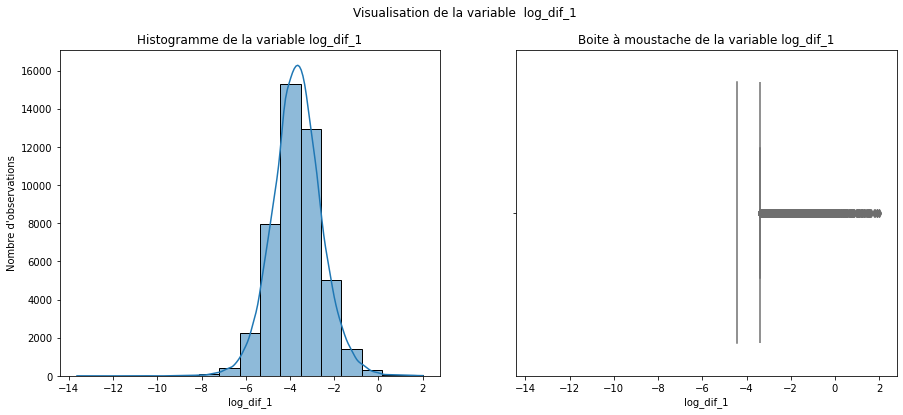

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Indicateurs de distribution
count    6.964300e+04
mean             -inf
std               NaN
min              -inf
25%               NaN
50%     -4.414980e+00
75%     -3.380143e+00
max      2.009522e+00
Name: log_dif_1, dtype: float64



In [684]:
for col in df_train_new_feat_smooth.select_dtypes(include=['float64',
                                                           'int64']):
    hist_box_plot(df_train_new_feat_smooth,
                  col,
                  subtitle=f"Visualisation de la variable  {col}",
                  hist_title=f'Histogramme de la variable {col}',
                  color='skyblue')

pep8(_ih)

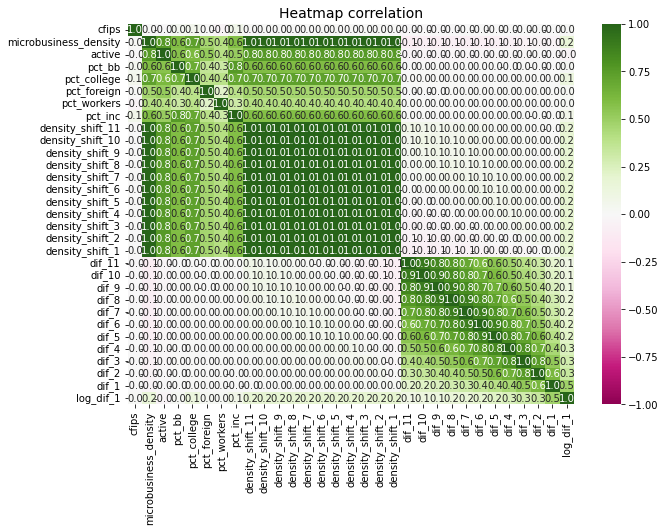

In [415]:
df_corr = df_train_new_feat_smooth.loc[:, ['row_id', 'cfips',
                                           'county', 'state',
                                           'first_day_of_month',
                                           'microbusiness_density',
                                           'active', 'pct_bb',
                                           'pct_college', 'pct_foreign',
                                           'pct_workers', 'pct_inc',
                                           'density_shift_11',
                                           'density_shift_10',
                                           'density_shift_9',
                                           'density_shift_8',
                                           'density_shift_7',
                                           'density_shift_6',
                                           'density_shift_5',
                                           'density_shift_4',
                                           'density_shift_3',
                                           'density_shift_2',
                                           'density_shift_1', 'dif_11',
                                           'dif_10', 'dif_9', 'dif_8',
                                           'dif_7', 'dif_6', 'dif_5',
                                           'dif_4', 'dif_3', 'dif_2',
                                           'dif_1', 'log_dif_1']]

heatmap(df_corr)

pep8(_ih)

#dataframe for prediction with density shift features 

##df pred density

In [416]:
df_pred_density = df_train_new_feat_smooth.loc[:, ['row_id', 'active', 'year',
                                                   'month', 'dcount',
                                                   'county_i', 'state_i',
                                                   'pct_bb', 'pct_college',
                                                   'pct_foreign',
                                                   'pct_workers',
                                                   'pct_inc',
                                                   'density_shift_11',
                                                   'density_shift_10',
                                                   'density_shift_9',
                                                   'density_shift_8',
                                                   'density_shift_7',
                                                   'density_shift_6',
                                                   'density_shift_5',
                                                   'density_shift_4',
                                                   'density_shift_3',
                                                   'density_shift_2',
                                                   'density_shift_1',
                                                   'microbusiness_density']]

pep8(_ih)

In [417]:
df_pred_density.set_index(['row_id'], inplace=True)

pep8(_ih)

In [418]:
df_pred_density.isna().sum()

pep8(_ih)

##Data features/target

In [419]:
X_density = df_pred_density.iloc[:, :-1].copy(deep=True)
y_density = df_pred_density["microbusiness_density"].copy(deep=True)

pep8(_ih)

##Preproc - Normalisation 

###RobustScaler

In [420]:
X_density_to_rs = X_density.iloc[:, 6:]
X_density_to_rs.head(3)

pep8(_ih)

In [421]:
# get data more normalize with RobustScaler
X_density_rs = RobustScaler().fit_transform(X_density_to_rs)

pep8(_ih)

In [422]:
df_X_density_rs_ = pd.DataFrame(data=X_density_rs,
                                columns=X_density_to_rs.columns,
                                index=X_density_to_rs.index)
df_X_density_rs_.head(3)

pep8(_ih)

In [423]:
X_density_ = X_density.iloc[:, 1:6]

pep8(_ih)

In [424]:
df_X_density_rs = pd.concat([X_density_, df_X_density_rs_], axis=1)

pep8(_ih)

###Standard Scaler

In [425]:
X_density_to_Sts = X_density.iloc[:, 6:]

pep8(_ih)

In [426]:
# the scaler object (model)
scaler = StandardScaler()
# fit and transform the data
X_density_Sts = scaler.fit_transform(X_density_to_Sts)

pep8(_ih)

In [427]:
df_X_density_Sts_ = pd.DataFrame(data=X_density_Sts,
                                 columns=X_density_to_Sts.columns,
                                 index=X_density_to_Sts.index)
df_X_density_Sts_.head(3)

pep8(_ih)

In [428]:
X_density_1 = X_density.iloc[:, 1:6]

pep8(_ih)

In [429]:
df_X_density_Sts = pd.concat([X_density_1, df_X_density_Sts_], axis=1)
df_X_density_Sts.head(3)

pep8(_ih)

##Split data

###RobustScaler and features shifts

In [430]:
X_density_shift = df_X_density_rs.copy(deep=True)
y_density_shift = df_pred_density["microbusiness_density"].copy(deep=True)

pep8(_ih)

In [431]:
train_start = round(X_density_shift.shape[0]*0.15)
train_end = X_density_shift.shape[0]

pep8(_ih)

In [432]:
X_density_shift_train = X_density_shift.iloc[train_start:train_end]
X_density_shift_train.head(3)

pep8(_ih)

In [433]:
X_density_shift_test = X_density_shift.iloc[0:train_start-1]
X_density_shift_test.head(3)

pep8(_ih)

In [434]:
y_density_shift_train = y_density_shift[train_start:train_end]
y_density_shift_train.head(3)

pep8(_ih)

In [435]:
y_density_shift_test = y_density_shift[0:train_start-1]
y_density_shift_test.head(3)

pep8(_ih)

##Linear Reg

In [436]:
model_lr = LinearRegression()
model_lr.fit(X_density_shift_train,
             y_density_shift_train)

pep8(_ih)

In [437]:
y_pred_lr = model_lr.predict(X_density_shift_test)

pep8(_ih)

In [438]:
smape(y_density_shift_test, y_pred_lr)

pep8(_ih)

##Pred for sample submission with Linear Reg

###RobustScaler

In [439]:
x_test_origin = df_all_test.loc[:, ['pct_bb',
                                    'pct_college',
                                    'pct_foreign',
                                    'pct_workers',
                                    'pct_inc']]

pep8(_ih)

In [440]:
# get data more normalize with RobustScaler
X_test_ = RobustScaler().fit_transform(x_test_origin)

pep8(_ih)

In [441]:
df_X_test_ = pd.DataFrame(data=X_test_,
                          columns=x_test_origin.columns,
                          index=x_test_origin.index)

pep8(_ih)

In [442]:
df_test_ = df_all_test.loc[:, ["row_id",
                               'cfips',
                               'year',
                               'month',
                               'dcount',
                               'county_i',
                               'state_i']]

pep8(_ih)

###Dataframe normalisé avec RS - df_X_test_rs

In [443]:
df_X_test_rs = pd.concat([df_test_, df_X_test_], axis=1)

pep8(_ih)

#### 1.predict microdensity 1122 : adding features density (1 to 11) with data train from 12/21 to 10/22

#####**2022 Nov from test data**

In [444]:
df_X_test_rs_1122 = df_X_test_rs.query("year==2022 & month == 11")

pep8(_ih)

**data from train**

In [445]:
df_all_train_2022 = df_all_train.loc[:, ['row_id',
                                         'cfips',
                                         'microbusiness_density',
                                         'year',
                                         'month']].query("year == 2022")

pep8(_ih)

In [446]:
df_all_train_122021 = df_all_train.loc[:, ['row_id',
                                           'cfips',
                                           'microbusiness_density',
                                           'year',
                                           'month']].query("year == 2021 \
                                           & month == 12")

pep8(_ih)

In [447]:
df_1122 = pd.concat((df_all_train_2022, df_all_train_122021))
df_1122 = df_1122.sort_values(["month",
                               "year"], ascending=False).reset_index(drop=True)

pep8(_ih)

#####**add with micro density from 122021 - 102022 (data df_1122) to data test normalized (df_X_test_rs)**

In [448]:
df_test_predict_1122 = pd.concat([df_X_test_rs_1122, df_1122], join="outer")
df_test_predict_1122.shape

pep8(_ih)

In [449]:
df_test_predict_1122.sort_values(["year",
                                  "month"],
                                 ascending=[False, False],
                                 inplace=True)
df_test_predict_1122.head(3)

pep8(_ih)

In [450]:
df_test_predict_1122.reset_index(inplace=True, drop=True)

pep8(_ih)

In [451]:
df_test_predict_1122_new_feat = df_test_predict_1122.copy(deep=True)

pep8(_ih)

In [452]:
df_1122_1 = new_features(df_test_predict_1122_new_feat)
df_1122_1.head(3)

pep8(_ih)

In [453]:
df_1122_new = new_features1(df_1122_1, col=df_1122_1.iloc[:, 13:].columns)
df_1122_new.head(3)

pep8(_ih)

In [454]:
df_1122_density = df_1122_new.iloc[:, [0, 13, 14, 15, 16,
                                       17, 18, 19, 20, 21, 22, 23]]

pep8(_ih)

In [455]:
df_1122_to_fit = pd.merge(df_X_test_rs_1122, df_1122_density,
                          how="left", on=["row_id"])

pep8(_ih)

In [456]:
# verif
df_train_smoothy.query('year == 2022 & month == 10 & cfips == 1001')

pep8(_ih)

In [457]:
df_1122_to_fit.isna().sum()

pep8(_ih)

#####Prepare data 1122 to fit

In [458]:
df_1122_to_fit.set_index(['row_id'], inplace=True)
df_1122_to_fit.drop(columns="cfips", inplace=True)
df_1122_to_fit.head(3)

pep8(_ih)

#####predict

In [459]:
y_pred_1122 = model_lr.predict(df_1122_to_fit)
y_pred_1122

pep8(_ih)

In [460]:
df_1122_pred = pd.DataFrame(data=y_pred_1122, index=df_1122_to_fit.index,
                            columns=["microbusiness_density"])
df_1122_pred.head(3)

pep8(_ih)

#####add 112022 microbusiness_density predicted to test

In [461]:
df_1122_pred.reset_index(inplace=True)

pep8(_ih)

#####predict df 112022 - export to csv

In [462]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/df_1122_pred.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_1122_pred.to_csv(filepath)

pep8(_ih)

In [463]:
df_all_test_density_1122 = pd.merge(df_all_test, df_1122_pred, on=["row_id"],
                                    how="left")
df_all_test_density_1122.drop(columns="microbusiness_density_x", inplace=True)
df_all_test_density_1122.rename(columns={"microbusiness_density_y":
                                         "microbusiness_density"},
                                inplace=True)

pep8(_ih)

In [464]:
# verif
df_all_test_density_1122.microbusiness_density.notnull().sum()

pep8(_ih)

####2.predict microdensity 1222 : adding features density (1 to 11) with data train from 01/22 to 11/22

#####**2022 dec from test data**

In [465]:
df_X_test_rs_1222 = df_X_test_rs.query("year == 2022 & month == 12")

pep8(_ih)

#####**data from train**

In [466]:
df_all_train_2022 = df_all_train.loc[:, ['row_id',
                                         'cfips',
                                         'microbusiness_density',
                                         'year',
                                         'month']].query("year == 2022")

pep8(_ih)

In [467]:
df_1222 = df_all_train_2022.sort_values(["month", "year"],
                                        ascending=False).reset_index(drop=True)

pep8(_ih)

#####**add data (predicted) 11/22 to data train**

In [468]:
df_1122_pred_to_add = df_1122_pred.copy(deep=True)

pep8(_ih)

In [469]:
df_split = df_1122_pred_to_add.row_id.str.split('-', expand=True)
df_split.rename(columns={1: "month", 2: "day"}, inplace=True)
df_split["month"] = df_split["month"].astype('int')

pep8(_ih)

In [470]:
df_1122_pred_to_add_new = df_1122_pred_to_add.copy(deep=True)

pep8(_ih)

In [471]:
df_split_ = df_split.loc[:, 0].str.split('_', expand=True)
df_split_.rename(columns={0: "cfips", 1: "year"}, inplace=True)
df_split_["cfips"] = df_split_["cfips"].astype('int')
df_split_["year"] = df_split_["year"].astype('int')

pep8(_ih)

In [472]:
df_1122_pred_to_add_new = pd.concat((df_1122_pred_to_add, df_split_, df_split),
                                    axis=1)
df_1122_pred_to_add_new.drop(columns=[0, "day"], axis=1, inplace=True)

pep8(_ih)

In [473]:
df_1122_pred_to_add_new = (
    df_1122_pred_to_add_new.
    reindex(columns=df_all_train_2022.columns))

pep8(_ih)

In [474]:
df_1222_ = pd.concat((df_1222, df_1122_pred_to_add_new)).\
                      sort_values(["month", "year"],
                                  ascending=False)

pep8(_ih)

#####**create and add micro density from 012022 - 112022 (data df_1222_) to data test normalized (df_X_test_rs)**

In [475]:
df_test_predict_1222 = pd.concat([df_X_test_rs_1222, df_1222_], join="outer")

pep8(_ih)

In [476]:
df_test_predict_1222.sort_values(["year", "month"],
                                 ascending=[False, False],
                                 inplace=True)
pep8(_ih)

In [477]:
df_test_predict_1222.reset_index(inplace=True, drop=True)

pep8(_ih)

In [478]:
df_test_predict_1222_new_feat = df_test_predict_1222.copy(deep=True)

pep8(_ih)

In [479]:
df_1222_1 = new_features(df_test_predict_1222_new_feat)
df_1222_1.head(3)

pep8(_ih)

In [480]:
df_1222_ = new_features1(df_1222_1, col=df_1122.iloc[:, 13:].columns)

pep8(_ih)

In [481]:
df_1222_density = df_1222_.iloc[:, [0, 13, 14, 15, 16, 17,
                                    18, 19, 20, 21, 22, 23]]

pep8(_ih)

In [482]:
df_1222_to_fit = pd.merge(df_X_test_rs_1222, df_1222_density,
                          how="left", on=["row_id"])

pep8(_ih)

In [483]:
# Verif
df_1222_to_fit.isna().sum()

pep8(_ih)

#####Prepare data 1222 to fit

In [484]:
df_1222_to_fit.set_index(['row_id'], inplace=True)
df_1222_to_fit.drop(columns="cfips", inplace=True)

pep8(_ih)

#####predict

In [485]:
y_pred_1222 = model_lr.predict(df_1222_to_fit)

pep8(_ih)

In [486]:
df_1222_pred = pd.DataFrame(data=y_pred_1222,
                            index=df_1222_to_fit.index,
                            columns=["microbusiness_density"])

pep8(_ih)

#####export to csv

In [487]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/df_1222_pred.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_1222_pred.to_csv(filepath)

pep8(_ih)

####3.predict microdensity 01/23 : adding features density (1 to 11) with data train from 02/22 to 12/22

#####**2023 janv from test data**

In [488]:
df_X_test_rs_0123 = df_X_test_rs.query("year == 2023 & month == 1")

pep8(_ih)

#####**data from train**

In [489]:
df_all_train_2022 = df_all_train.loc[:, ['row_id',
                                         'cfips',
                                         'microbusiness_density',
                                         'year',
                                         'month']].query("year == 2022")

pep8(_ih)

In [490]:
df_0123 = df_all_train_2022.sort_values(["month", "year"],
                                        ascending=False).reset_index(drop=True)

pep8(_ih)

#####**add data (predicted) 11/22 and 12/22 to data train**

In [491]:
df_1122_pred_to_add = df_1122_pred.copy(deep=True)

pep8(_ih)

In [492]:
df_1222_pred_to_add = df_1222_pred.copy(deep=True)
df_1222_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [493]:
df_pred_to_add = pd.concat((df_1122_pred_to_add, df_1222_pred_to_add), axis=0)

pep8(_ih)

In [494]:
df_split = df_pred_to_add.row_id.str.split('-', expand=True)
df_split.rename(columns={1: "month", 2: "day"}, inplace=True)
df_split["month"] = df_split["month"].astype('int')

pep8(_ih)

In [495]:
df_split_ = df_split.loc[:, 0].str.split('_', expand=True)
df_split_.rename(columns={0: "cfips", 1: "year"}, inplace=True)
df_split_["cfips"] = df_split_["cfips"].astype('int')
df_split_["year"] = df_split_["year"].astype('int')

pep8(_ih)

In [496]:
df_pred_to_add_new = pd.concat((df_pred_to_add, df_split_, df_split), axis=1)
df_pred_to_add_new.drop(columns=[0, "day"], axis=1, inplace=True)

pep8(_ih)

In [497]:
df_pred_to_add_new = df_pred_to_add_new.\
                     reindex(columns=df_all_train_2022.columns)

pep8(_ih)

In [498]:
df_0123_ = pd.concat((df_0123, df_pred_to_add_new)).\
                      sort_values(["month", "year"],
                                  ascending=False)

pep8(_ih)

#####**create and add micro density from 022022 - 122022 (data df_0123_) to data test normalized (df_X_test_rs)**

In [499]:
df_test_predict_0123 = pd.concat([df_X_test_rs_0123, df_0123_], join="outer")

pep8(_ih)

In [500]:
df_test_predict_0123.sort_values(["year", "month"],
                                 ascending=[False, False],
                                 inplace=True)

pep8(_ih)

In [501]:
df_test_predict_0123.reset_index(inplace=True, drop=True)

pep8(_ih)

In [502]:
df_test_predict_0123_new_feat = df_test_predict_0123.copy(deep=True)

pep8(_ih)

In [503]:
df_0123_1 = new_features(df_test_predict_0123_new_feat)

pep8(_ih)

In [504]:
df_0123_ = new_features1(df_0123_1, col=df_0123_1.iloc[:, 13:].columns)

pep8(_ih)

In [505]:
df_0123_density = df_0123_.iloc[:, [0, 13, 14, 15, 16, 17,
                                    18, 19, 20, 21, 22, 23]]

pep8(_ih)

In [506]:
df_0123_to_fit = pd.merge(df_X_test_rs_0123, df_0123_density, how="left",
                          on=["row_id"])

pep8(_ih)

In [507]:
# verif
df_0123_to_fit.isna().sum()

pep8(_ih)

#####Prepare data to fit

In [508]:
df_0123_to_fit.set_index(['row_id'], inplace=True)
df_0123_to_fit.drop(columns="cfips", inplace=True)

pep8(_ih)

#####predict

In [509]:
y_pred_0123 = model_lr.predict(df_0123_to_fit)

pep8(_ih)

In [510]:
df_0123_pred = pd.DataFrame(data=y_pred_0123,
                            index=df_0123_to_fit.index,
                            columns=["microbusiness_density"])
df_0123_pred.head(3)

pep8(_ih)

#####export to csv

In [511]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/df_0123_pred.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_0123_pred.to_csv(filepath)

pep8(_ih)

####4.predict microdensity 02/23 : adding features density (1 to 11) with data train from 03/22 to 01/23

#####**2023 feb - from test data**

In [512]:
df_X_test_rs_0223 = df_X_test_rs.query("year == 2023 & month == 2")

pep8(_ih)

#####**data from train**

In [513]:
df_all_train_2022 = df_all_train.loc[:, ['row_id',
                                         'cfips',
                                         'microbusiness_density',
                                         'year',
                                         'month']].query("year == 2022")

pep8(_ih)

In [514]:
df_0223 = df_all_train_2022.sort_values(["month",
                                         "year"],
                                        ascending=False).\
                                        reset_index(drop=True)

pep8(_ih)

#####**add data (predicted) 11/22 and 12/22 to data train**

In [515]:
df_1122_pred_to_add = df_1122_pred.copy(deep=True)

pep8(_ih)

In [516]:
df_1222_pred_to_add = df_1222_pred.copy(deep=True)
df_1222_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [517]:
df_0123_pred_to_add = df_0123_pred.copy(deep=True)
df_0123_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [518]:
df_pred_to_add = pd.concat((df_1122_pred_to_add,
                            df_1222_pred_to_add,
                            df_0123_pred_to_add), axis=0)

pep8(_ih)

In [519]:
df_split = df_pred_to_add.row_id.str.split('-', expand=True)
df_split.rename(columns={1: "month", 2: "day"}, inplace=True)
df_split["month"] = df_split["month"].astype('int')

pep8(_ih)

In [520]:
df_split_ = df_split.loc[:, 0].str.split('_', expand=True)
df_split_.rename(columns={0: "cfips", 1: "year"}, inplace=True)
df_split_["cfips"] = df_split_["cfips"].astype('int')
df_split_["year"] = df_split_["year"].astype('int')

pep8(_ih)

In [521]:
df_pred_to_add_new = pd.concat((df_pred_to_add,
                               df_split_,
                               df_split), axis=1)
df_pred_to_add_new.drop(columns=[0, "day"], axis=1, inplace=True)

pep8(_ih)

In [522]:
df_pred_to_add_new = df_pred_to_add_new.\
                     reindex(columns=df_all_train_2022.columns)

pep8(_ih)

In [523]:
df_0223_ = pd.concat((df_0223, df_pred_to_add_new)).\
                      sort_values(["month", "year"], ascending=False)

pep8(_ih)

#####**create and add micro density to data test normalized (df_X_test_rs)**

In [524]:
df_test_predict_0223 = pd.concat([df_X_test_rs_0223, df_0223_], join="outer")

pep8(_ih)

In [525]:
df_test_predict_0223.sort_values(["year",
                                  "month"],
                                 ascending=[False, False], inplace=True)

pep8(_ih)

In [526]:
df_test_predict_0223.reset_index(inplace=True, drop=True)

pep8(_ih)

In [527]:
df_test_predict_0223_new_feat = df_test_predict_0223.copy(deep=True)

pep8(_ih)

In [528]:
df_0223_1 = new_features(df_test_predict_0223_new_feat)

pep8(_ih)

In [529]:
df_0223_ = new_features1(df_0223_1, col=df_0223_1.iloc[:, 13:].columns)

pep8(_ih)

In [530]:
df_0223_density = df_0223_.iloc[:, [0, 13, 14, 15, 16, 17,
                                    18, 19, 20, 21, 22, 23]]
pep8(_ih)

In [531]:
df_0223_to_fit = pd.merge(df_X_test_rs_0223, df_0223_density,
                          how="left", on=["row_id"])

pep8(_ih)

In [532]:
# verif
df_0223_to_fit.isna().sum()

pep8(_ih)

#####Prepare data to fit

In [533]:
df_0223_to_fit.set_index(['row_id'], inplace=True)
df_0223_to_fit.drop(columns="cfips", inplace=True)

pep8(_ih)

#####predict

In [534]:
y_pred_0223 = model_lr.predict(df_0223_to_fit)

pep8(_ih)

In [535]:
df_0223_pred = pd.DataFrame(data=y_pred_0223,
                            index=df_0223_to_fit.index,
                            columns=["microbusiness_density"])

pep8(_ih)

#####export to csv

In [536]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/df_0223_pred.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_0223_pred.to_csv(filepath)

pep8(_ih)

####5.predict microdensity 03/23 : adding features density (1 to 11) with data train from 04/22 to 02/23

#####2023 march - from test data

In [537]:
df_X_test_rs_0323 = df_X_test_rs.query("year == 2023 & month == 3")

pep8(_ih)

#####**data from train**

In [538]:
df_all_train_2022 = df_all_train.loc[:, ['row_id',
                                         'cfips',
                                         'microbusiness_density',
                                         'year',
                                         'month']].query("year == 2022")

pep8(_ih)

In [539]:
df_0323 = df_all_train_2022.sort_values(["month",
                                         "year"],
                                        ascending=False).\
                                        reset_index(drop=True)

pep8(_ih)

#####**add data (predicted) from 11/22 to 02/23 to data train**

In [540]:
df_1122_pred_to_add = df_1122_pred.copy(deep=True)

pep8(_ih)

In [541]:
df_1222_pred_to_add = df_1222_pred.copy(deep=True)
df_1222_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [542]:
df_0123_pred_to_add = df_0123_pred.copy(deep=True)
df_0123_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [543]:
df_0223_pred_to_add = df_0223_pred.copy(deep=True)
df_0223_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [544]:
df_pred_to_add = pd.concat((df_1122_pred_to_add,
                            df_1222_pred_to_add,
                            df_0123_pred_to_add,
                            df_0223_pred_to_add), axis=0)

pep8(_ih)

In [545]:
df_split = df_pred_to_add.row_id.str.split('-', expand=True)
df_split.rename(columns={1: "month", 2: "day"}, inplace=True)
df_split["month"] = df_split["month"].astype('int')

pep8(_ih)

In [546]:
df_split_ = df_split.loc[:, 0].str.split('_', expand=True)
df_split_.rename(columns={0: "cfips", 1: "year"}, inplace=True)
df_split_["cfips"] = df_split_["cfips"].astype('int')
df_split_["year"] = df_split_["year"].astype('int')

pep8(_ih)

In [547]:
df_pred_to_add_new = pd.concat((df_pred_to_add, df_split_, df_split), axis=1)
df_pred_to_add_new.drop(columns=[0, "day"], axis=1, inplace=True)

pep8(_ih)

In [548]:
df_pred_to_add_new = df_pred_to_add_new.\
                      reindex(columns=df_all_train_2022.columns)

pep8(_ih)

In [549]:
df_0323_ = pd.concat((df_0323, df_pred_to_add_new)).\
                      sort_values(["month", "year"], ascending=False)

pep8(_ih)

#####**create and add micro density to data test normalized (df_X_test_rs)**

In [550]:
df_test_predict_0323 = pd.concat([df_X_test_rs_0323, df_0323_], join="outer")

pep8(_ih)

In [551]:
df_test_predict_0323.sort_values(["year", "month"],
                                 ascending=[False, False],
                                 inplace=True)

pep8(_ih)

In [552]:
df_test_predict_0323.reset_index(inplace=True, drop=True)

pep8(_ih)

In [553]:
df_test_predict_0323_new_feat = df_test_predict_0323.copy(deep=True)

pep8(_ih)

In [554]:
df_0323_1 = new_features(df_test_predict_0323_new_feat)

pep8(_ih)

In [555]:
df_0323_ = new_features1(df_0323_1, col=df_0323_1.iloc[:, 13:].columns)

pep8(_ih)

In [556]:
df_0323_density = df_0323_.iloc[:, [0, 13, 14, 15, 16, 17,
                                    18, 19, 20, 21, 22, 23]]

pep8(_ih)

In [557]:
df_0323_to_fit = pd.merge(df_X_test_rs_0323, df_0323_density,
                          how="left", on=["row_id"])

pep8(_ih)

In [558]:
# verif
df_0323_to_fit.isna().sum()

pep8(_ih)

#####Prepare data to fit

In [559]:
df_0323_to_fit.set_index(['row_id'], inplace=True)

pep8(_ih)

In [560]:
df_0323_to_fit.drop(columns="cfips", inplace=True)

pep8(_ih)

#####predict

In [561]:
y_pred_0323 = model_lr.predict(df_0323_to_fit)

pep8(_ih)

In [562]:
df_0323_pred = pd.DataFrame(data=y_pred_0323,
                            index=df_0323_to_fit.index,
                            columns=["microbusiness_density"])
df_0323_pred.head(3)

pep8(_ih)

#####export to csv

In [563]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/df_0323_pred.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_0323_pred.to_csv(filepath)

pep8(_ih)

####6.predict microdensity 04/23 : adding features density (1 to 11) with data train from 05/22 to 03/23

#####2023 april - from test data

In [564]:
df_X_test_rs_0423 = df_X_test_rs.query("year == 2023 & month == 4")

pep8(_ih)

#####**data from train**

In [565]:
df_all_train_2022 = df_all_train.loc[:, ['row_id',
                                         'cfips',
                                         'microbusiness_density',
                                         'year',
                                         'month']].query("year == 2022")

pep8(_ih)

In [566]:
df_0423 = df_all_train_2022.sort_values(["month",
                                         "year"],
                                        ascending=False).\
                                        reset_index(drop=True)

pep8(_ih)

#####**add data (predicted)to data train**

In [567]:
df_1122_pred_to_add = df_1122_pred.copy(deep=True)

pep8(_ih)

In [568]:
df_1222_pred_to_add = df_1222_pred.copy(deep=True)
df_1222_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [569]:
df_0123_pred_to_add = df_0123_pred.copy(deep=True)
df_0123_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [570]:
df_0223_pred_to_add = df_0223_pred.copy(deep=True)
df_0223_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [571]:
df_0323_pred_to_add = df_0323_pred.copy(deep=True)
df_0323_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [572]:
df_pred_to_add = pd.concat((df_1122_pred_to_add,
                            df_1222_pred_to_add,
                            df_0123_pred_to_add,
                            df_0223_pred_to_add,
                            df_0323_pred_to_add), axis=0)

pep8(_ih)

In [573]:
df_split = df_pred_to_add.row_id.str.split('-', expand=True)
df_split.rename(columns={1: "month", 2: "day"}, inplace=True)
df_split["month"] = df_split["month"].astype('int')

pep8(_ih)

In [574]:
df_split_ = df_split.loc[:, 0].str.split('_', expand=True)
df_split_.rename(columns={0: "cfips", 1: "year"}, inplace=True)
df_split_["cfips"] = df_split_["cfips"].astype('int')
df_split_["year"] = df_split_["year"].astype('int')

pep8(_ih)

In [575]:
df_pred_to_add_new = pd.concat((df_pred_to_add, df_split_, df_split), axis=1)
df_pred_to_add_new.drop(columns=[0, "day"], axis=1, inplace=True)

pep8(_ih)

In [576]:
df_pred_to_add_new = df_pred_to_add_new.\
                     reindex(columns=df_all_train_2022.columns)

pep8(_ih)

In [577]:
df_0423_ = pd.concat((df_0423, df_pred_to_add_new))\
                      .sort_values(["month", "year"], ascending=False)

pep8(_ih)

#####**create and add micro density to data test normalized (df_X_test_rs)**

In [578]:
df_test_predict_0423 = pd.concat([df_X_test_rs_0423, df_0423_], join="outer")

pep8(_ih)

In [579]:
df_test_predict_0423.sort_values(["year", "month"],
                                 ascending=[False, False], inplace=True)

pep8(_ih)

In [580]:
df_test_predict_0423.reset_index(inplace=True, drop=True)

pep8(_ih)

In [581]:
df_test_predict_0423_new_feat = df_test_predict_0423.copy(deep=True)

pep8(_ih)

In [582]:
df_0423_1 = new_features(df_test_predict_0423_new_feat)

pep8(_ih)

In [583]:
df_0423_ = new_features1(df_0423_1, col=df_0423_1.iloc[:, 13:].columns)

pep8(_ih)

In [584]:
df_0423_density = df_0423_.iloc[:, [0, 13, 14, 15, 16, 17,
                                    18, 19, 20, 21, 22, 23]]

pep8(_ih)

In [585]:
df_0423_to_fit = pd.merge(df_X_test_rs_0423, df_0423_density,
                          how="left", on=["row_id"])

pep8(_ih)

In [586]:
# verif
df_0423_to_fit.isna().sum()

pep8(_ih)

#####Prepare data to fit

In [587]:
df_0423_to_fit.set_index(['row_id'], inplace=True)
df_0423_to_fit.drop(columns="cfips", inplace=True)

pep8(_ih)

#####predict

In [588]:
y_pred_0423 = model_lr.predict(df_0423_to_fit)

pep8(_ih)

In [589]:
df_0423_pred = pd.DataFrame(data=y_pred_0423, index=df_0423_to_fit.index,
                            columns=["microbusiness_density"])

pep8(_ih)

#####export to csv

In [590]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/df_0423_pred.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_0423_pred.to_csv(filepath)

pep8(_ih)

####7.predict microdensity 05/23 : adding features density (1 to 11) with data train from 06/22 to 04/23

#####2023 may - from test data

In [591]:
df_X_test_rs_0523 = df_X_test_rs.query("year == 2023 & month == 5")

pep8(_ih)

#####**data from train**

In [592]:
df_all_train_2022 = df_all_train.loc[:, ['row_id',
                                         'cfips',
                                         'microbusiness_density',
                                         'year',
                                         'month']].query("year == 2022")

pep8(_ih)

In [593]:
df_0523 = df_all_train_2022.sort_values(["month",
                                         "year"],
                                        ascending=False)\
                                         .reset_index(drop=True)

pep8(_ih)

#####**add data (predicted) to data train**

In [594]:
df_1122_pred_to_add = df_1122_pred.copy(deep=True)

pep8(_ih)

In [595]:
df_1222_pred_to_add = df_1222_pred.copy(deep=True)
df_1222_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [596]:
df_0123_pred_to_add = df_0123_pred.copy(deep=True)
df_0123_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [597]:
df_0223_pred_to_add = df_0223_pred.copy(deep=True)
df_0223_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [598]:
df_0323_pred_to_add = df_0323_pred.copy(deep=True)
df_0323_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [599]:
df_0423_pred_to_add = df_0423_pred.copy(deep=True)
df_0423_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [600]:
df_pred_to_add = pd.concat((df_1122_pred_to_add,
                            df_1222_pred_to_add,
                            df_0123_pred_to_add,
                            df_0223_pred_to_add,
                            df_0323_pred_to_add,
                            df_0423_pred_to_add), axis=0)

pep8(_ih)

In [601]:
df_split = df_pred_to_add.row_id.str.split('-', expand=True)
df_split.rename(columns={1: "month", 2: "day"}, inplace=True)
df_split["month"] = df_split["month"].astype('int')

pep8(_ih)

In [602]:
df_split_ = df_split.loc[:, 0].str.split('_', expand=True)
df_split_.rename(columns={0: "cfips", 1: "year"}, inplace=True)
df_split_["cfips"] = df_split_["cfips"].astype('int')
df_split_["year"] = df_split_["year"].astype('int')

pep8(_ih)

In [603]:
df_pred_to_add_new = pd.concat((df_pred_to_add, df_split_, df_split), axis=1)
df_pred_to_add_new.drop(columns=[0, "day"], axis=1, inplace=True)

pep8(_ih)

In [604]:
df_pred_to_add_new = df_pred_to_add_new.\
                     reindex(columns=df_all_train_2022.columns)

pep8(_ih)

In [605]:
df_0523_ = pd.concat((df_0523, df_pred_to_add_new)).\
                               sort_values(["month", "year"], ascending=False)

pep8(_ih)

#####**create and add micro density to data test normalized (df_X_test_rs)**

In [606]:
df_test_predict_0523 = pd.concat([df_X_test_rs_0523, df_0523_], join="outer")

pep8(_ih)

In [607]:
df_test_predict_0523.sort_values(["year", "month"],
                                 ascending=[False, False],
                                 inplace=True)

pep8(_ih)

In [608]:
df_test_predict_0523.reset_index(inplace=True, drop=True)

pep8(_ih)

In [609]:
df_test_predict_0523_new_feat = df_test_predict_0523.copy(deep=True)

pep8(_ih)

In [610]:
df_0523_1 = new_features(df_test_predict_0523_new_feat)

pep8(_ih)

In [611]:
df_0523_ = new_features1(df_0523_1, col=df_0523_1.iloc[:, 13:].columns)

pep8(_ih)

In [612]:
df_0523_density = df_0523_.iloc[:, [0, 13, 14, 15, 16, 17,
                                    18, 19, 20, 21, 22, 23]]

pep8(_ih)

In [613]:
df_0523_to_fit = pd.merge(df_X_test_rs_0523, df_0523_density,
                          how="left", on=["row_id"])

pep8(_ih)

In [614]:
# verif
df_0523_to_fit.isna().sum()

pep8(_ih)

#####Prepare data to fit

In [615]:
df_0523_to_fit.set_index(['row_id'], inplace=True)
df_0523_to_fit.drop(columns="cfips", inplace=True)

pep8(_ih)

#####predict

In [616]:
y_pred_0523 = model_lr.predict(df_0523_to_fit)

pep8(_ih)

In [617]:
df_0523_pred = pd.DataFrame(data=y_pred_0523,
                            index=df_0523_to_fit.index,
                            columns=["microbusiness_density"])

pep8(_ih)

#####export to csv

In [618]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/df_0523_pred.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_0523_pred.to_csv(filepath)

pep8(_ih)

####8.predict microdensity 06/23 : adding features density (1 to 11) with data train from 07/22 to 05/23

#####2023 june - from test data

In [619]:
df_X_test_rs_0623 = df_X_test_rs.query("year == 2023 & month == 6")

pep8(_ih)

#####**data from train**

In [620]:
df_all_train_2022 = df_all_train.loc[:, ['row_id',
                                         'cfips',
                                         'microbusiness_density',
                                         'year',
                                         'month']].query("year == 2022")

pep8(_ih)

In [621]:
df_0623 = df_all_train_2022.sort_values(["month", "year"], ascending=False)\
                                                    .reset_index(drop=True)

pep8(_ih)

#####**add data (predicted) to data train**

In [622]:
df_1122_pred_to_add = df_1122_pred.copy(deep=True)

pep8(_ih)

In [623]:
df_1222_pred_to_add = df_1222_pred.copy(deep=True)
df_1222_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [624]:
df_0123_pred_to_add = df_0123_pred.copy(deep=True)
df_0123_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [625]:
df_0223_pred_to_add = df_0223_pred.copy(deep=True)
df_0223_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [626]:
df_0323_pred_to_add = df_0323_pred.copy(deep=True)
df_0323_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [627]:
df_0423_pred_to_add = df_0423_pred.copy(deep=True)
df_0423_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [628]:
df_0523_pred_to_add = df_0523_pred.copy(deep=True)
df_0523_pred_to_add.reset_index(inplace=True)

pep8(_ih)

In [629]:
df_pred_to_add = pd.concat((df_1122_pred_to_add,
                            df_1222_pred_to_add,
                            df_0123_pred_to_add,
                            df_0223_pred_to_add,
                            df_0323_pred_to_add,
                            df_0423_pred_to_add,
                            df_0523_pred_to_add), axis=0)

pep8(_ih)

In [630]:
df_split = df_pred_to_add.row_id.str.split('-', expand=True)
df_split.rename(columns={1: "month", 2: "day"}, inplace=True)
df_split["month"] = df_split["month"].astype('int')

pep8(_ih)

In [631]:
df_split_ = df_split.loc[:, 0].str.split('_', expand=True)
df_split_.rename(columns={0: "cfips", 1: "year"}, inplace=True)
df_split_["cfips"] = df_split_["cfips"].astype('int')
df_split_["year"] = df_split_["year"].astype('int')

pep8(_ih)

In [632]:
df_pred_to_add_new = pd.concat((df_pred_to_add, df_split_, df_split), axis=1)
df_pred_to_add_new.drop(columns=[0, "day"], axis=1, inplace=True)

pep8(_ih)

In [633]:
df_pred_to_add_new = df_pred_to_add_new.\
                     reindex(columns=df_all_train_2022.columns)

pep8(_ih)

In [634]:
df_0623_ = pd.concat((df_0623, df_pred_to_add_new)).\
                      sort_values(["month", "year"], ascending=False)

pep8(_ih)

#####**create and add micro density to data test normalized (df_X_test_rs)**

In [635]:
df_test_predict_0623 = pd.concat([df_X_test_rs_0623, df_0623_], join="outer")

pep8(_ih)

In [636]:
df_test_predict_0623.sort_values(["year", "month"],
                                 ascending=[False, False],
                                 inplace=True)

pep8(_ih)

In [637]:
df_test_predict_0623.reset_index(inplace=True, drop=True)

pep8(_ih)

In [638]:
df_test_predict_0623_new_feat = df_test_predict_0623.copy(deep=True)

pep8(_ih)

In [639]:
df_0623_1 = new_features(df_test_predict_0623_new_feat)

pep8(_ih)

In [640]:
df_0623_ = new_features1(df_0623_1, col=df_0623_1.iloc[:, 13:].columns)

pep8(_ih)

In [641]:
df_0623_density = df_0623_.iloc[:, [0, 13, 14, 15, 16, 17,
                                    18, 19, 20, 21, 22, 23]]

pep8(_ih)

In [642]:
df_0623_to_fit = pd.merge(df_X_test_rs_0623,
                          df_0623_density, how="left", on=["row_id"])

pep8(_ih)

In [643]:
# verif
df_0623_to_fit.isna().sum()

pep8(_ih)

#####Prepare data to fit

In [644]:
df_0623_to_fit.set_index(['row_id'], inplace=True)
df_0623_to_fit.drop(columns="cfips", inplace=True)

pep8(_ih)

#####predict

In [645]:
y_pred_0623 = model_lr.predict(df_0623_to_fit)

pep8(_ih)

In [646]:
df_0623_pred = pd.DataFrame(data=y_pred_0623,
                            index=df_0623_to_fit.index,
                            columns=["microbusiness_density"])

pep8(_ih)

#####export to csv

In [647]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/df_0623_pred.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_0623_pred.to_csv(filepath)

pep8(_ih)

##Random Forest

In [648]:
# instanciation du modèle avec paramètre de base
forest_reg = RandomForestRegressor(random_state=42, n_jobs=-1)
# fit model
forest_reg.fit(X_density_shift_train, y_density_shift_train)

pep8(_ih)

In [649]:
y_pred_rf = forest_reg.predict(X_density_shift_test)

pep8(_ih)

In [650]:
smape(y_density_shift_test, y_pred_rf)

pep8(_ih)

###Hyperparam & fit

In [651]:
custom_scorer = make_scorer(smape, greater_is_better=False)

pep8(_ih)

In [652]:
# Grille de recherche de la meilleure configuration d'hyperparamètre
# Ajout d'une validation croisée pour diminuer les risques d'overfitting
from sklearn.model_selection import GridSearchCV

params = [{
           "max_depth": [80, 90],
          }]

grid_search_rf = GridSearchCV(forest_reg,
                              params, cv=2,
                              scoring=custom_scorer)

grid_search_rf.fit(X_density_shift_train, y_density_shift_train)

pep8(_ih)

In [653]:
# Visualisation des meilleurs paramètres
grid_search_rf.best_params_

pep8(_ih)

In [654]:
grid_search_rf.best_estimator_

pep8(_ih)

In [655]:
# Attribution du modèle entraîné à une variable
rf_best_model_density = grid_search_rf.best_estimator_

y_pred_rf_boost_best_model_shift_rs = rf_best_model_density.\
                                      predict(X_density_shift_test)

smape(y_density_shift_test, y_pred_rf)

pep8(_ih)

##GradientBoosting StandardScaler

###Data GB StSc

In [656]:
X_density_shift_gb = df_X_density_Sts.copy(deep=True)
y_density_shift_gb = df_pred_density["microbusiness_density"].copy(deep=True)

pep8(_ih)

In [657]:
train_start = round(X_density_shift_gb.shape[0]*0.15)
train_end = X_density_shift_gb.shape[0]

pep8(_ih)

In [658]:
X_density_shift_gb_train = X_density_shift_gb.iloc[train_start:train_end]
X_density_shift_gb_test = X_density_shift_gb.iloc[0:train_start-1]

pep8(_ih)

In [659]:
y_density_shift_gb_train = y_density_shift_gb[train_start:train_end]
y_density_shift_gb_test = y_density_shift_gb[0:train_start-1]

pep8(_ih)

###Fit & Metric (RobustScaler)

In [660]:
from sklearn.ensemble import GradientBoostingRegressor
# instanciation du modèle avec paramètre de base
gdboost = GradientBoostingRegressor(random_state=42)
# fit model
gdboost.fit(X_density_shift_gb_train, y_density_shift_gb_train)

pep8(_ih)

In [661]:
y_pred = gdboost.predict(X_density_shift_gb_test)

pep8(_ih)

In [662]:
smape(y_density_shift_gb_test, y_pred)

pep8(_ih)

##GradientBoosting RobustScaler

###Data GB RobustScaler

In [663]:
X_density_shift_gb = df_X_density_rs.copy(deep=True)
y_density_shift_gb = df_pred_density["microbusiness_density"].copy(deep=True)

pep8(_ih)

In [664]:
train_start = round(X_density_shift_gb.shape[0]*0.15)
train_end = X_density_shift_gb.shape[0]

pep8(_ih)

In [665]:
X_density_shift_gb_train = X_density_shift_gb.iloc[train_start:train_end]
X_density_shift_gb_test = X_density_shift_gb.iloc[0:train_start-1]

pep8(_ih)

In [666]:
y_density_shift_gb_train = y_density_shift_gb[train_start:train_end]
y_density_shift_gb_test = y_density_shift_gb[0:train_start-1]

pep8(_ih)

###Fit & Metric (RobustScaler)

In [667]:
from sklearn.ensemble import GradientBoostingRegressor
# instanciation du modèle avec paramètre de base
gdboost = GradientBoostingRegressor(random_state=42)
# fit model
gdboost.fit(X_density_shift_gb_train, y_density_shift_gb_train)

pep8(_ih)

In [668]:
y_pred = gdboost.predict(X_density_shift_gb_test)

pep8(_ih)

In [669]:
smape(y_density_shift_gb_test, y_pred)

pep8(_ih)

###Hyperparam & fit

In [670]:
custom_scorer = make_scorer(smape, greater_is_better=False)

pep8(_ih)

In [671]:
# Grille de recherche de la meilleure configuration d'hyperparamètre
# Ajout d'une validation croisée pour diminuer les risques d'overfitting
from sklearn.model_selection import GridSearchCV

params = [{
           'subsample': [.5, .75]
           }]

grid_search = GridSearchCV(estimator=gdboost,
                           param_grid=params,
                           cv=2,
                           n_jobs=-1,
                           scoring=custom_scorer)

grid_search.fit(X_density_shift_gb_train, y_density_shift_gb_train)

pep8(_ih)

In [672]:
# Attribution du modèle entraîné à une variable
gb_best_model_density = grid_search.best_estimator_

y_pred_gdboost_best_model_shift_rs = gb_best_model_density.\
                                     predict(X_density_shift_gb_test)

smape(y_density_shift_gb_test, y_pred_gdboost_best_model_shift_rs)

pep8(_ih)

In [673]:
gb_best_model_density

pep8(_ih)

In [674]:
grid_search.best_params_

pep8(_ih)

#Sample submission

##concat all predicts

In [675]:
df_1222_pred.reset_index(inplace=True)

pep8(_ih)

In [676]:
df_0123_pred.reset_index(inplace=True)

pep8(_ih)

In [677]:
df_0223_pred.reset_index(inplace=True)

pep8(_ih)

In [678]:
df_0323_pred.reset_index(inplace=True)
df_0423_pred.reset_index(inplace=True)
df_0523_pred.reset_index(inplace=True)
df_0623_pred.reset_index(inplace=True)

pep8(_ih)

In [679]:
sample_submission = pd.concat((df_1122_pred,
                               df_1222_pred,
                               df_0123_pred,
                               df_0223_pred,
                               df_0323_pred,
                               df_0423_pred,
                               df_0523_pred,
                               df_0623_pred), axis=0)

pep8(_ih)

In [680]:
sample_submission

,row_id,microbusiness_density
0,1001_2022-11-01,12.498825
1,1003_2022-11-01,26.496683
2,1005_2022-11-01,6.106254
3,1007_2022-11-01,6.283638
4,1009_2022-11-01,7.844739
...,...,...
3130,56037_2023-06-01,6550.114152
3131,56039_2023-06-01,42749.402800
3132,56041_2023-06-01,8323.179123
3133,56043_2023-06-01,7000.984895


##to_csv

In [681]:
from pathlib import Path
filepath = Path('/content/drive/MyDrive/OpenClassRoom/P8/csv/'
                'sample_submission.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
sample_submission.to_csv(filepath, index=False)

pep8(_ih)